# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.ReLU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Dropout(p = 0.01),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size)
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
#scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 1200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    #scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/1200, Iteration 1/12, Loss: 1.1526
Epoch 1/1200, Iteration 2/12, Loss: 0.9399
Epoch 1/1200, Iteration 3/12, Loss: 0.9217
Epoch 1/1200, Iteration 4/12, Loss: 0.8670
Epoch 1/1200, Iteration 5/12, Loss: 0.8785
Epoch 1/1200, Iteration 6/12, Loss: 1.0275
Epoch 1/1200, Iteration 7/12, Loss: 0.7393
Epoch 1/1200, Iteration 8/12, Loss: 0.7220
Epoch 1/1200, Iteration 9/12, Loss: 0.7636
Epoch 1/1200, Iteration 10/12, Loss: 0.5999
Epoch 1/1200, Iteration 11/12, Loss: 0.7545
Epoch 1/1200, Iteration 12/12, Loss: 0.5640
Epoch 1/1200, Iteration 13/12, Loss: 0.6209
Train Error: 
 Accuracy: 49.62%, Avg loss: 0.610066, MRE: 0.520155, MAE: 0.081696 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.566214, MRE: 0.420494, MAE: 0.072968 

Epoch 2/1200, Iteration 1/12, Loss: 0.4474
Epoch 2/1200, Iteration 2/12, Loss: 0.5450
Epoch 2/1200, Iteration 3/12, Loss: 0.7424
Epoch 2/1200, Iteration 4/12, Loss: 0.5076
Epoch 2/1200, Iteration 5/12, Loss: 0.5474
Epoch 2/1200, Iteration 6/12, Loss: 0.5533
Epoch 2/1200,

Train Error: 
 Accuracy: 85.5%, Avg loss: 0.036446, MRE: 0.088457, MAE: 0.015077 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.030004, MRE: 0.075210, MAE: 0.014157 

Epoch 13/1200, Iteration 1/12, Loss: 0.0537
Epoch 13/1200, Iteration 2/12, Loss: 0.0461
Epoch 13/1200, Iteration 3/12, Loss: 0.0411
Epoch 13/1200, Iteration 4/12, Loss: 0.0169
Epoch 13/1200, Iteration 5/12, Loss: 0.0621
Epoch 13/1200, Iteration 6/12, Loss: 0.0230
Epoch 13/1200, Iteration 7/12, Loss: 0.0234
Epoch 13/1200, Iteration 8/12, Loss: 0.0504
Epoch 13/1200, Iteration 9/12, Loss: 0.0202
Epoch 13/1200, Iteration 10/12, Loss: 0.0228
Epoch 13/1200, Iteration 11/12, Loss: 0.0380
Epoch 13/1200, Iteration 12/12, Loss: 0.0425
Epoch 13/1200, Iteration 13/12, Loss: 0.0369
Train Error: 
 Accuracy: 84.25%, Avg loss: 0.033321, MRE: 0.083099, MAE: 0.014322 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.026941, MRE: 0.070418, MAE: 0.013524 

Epoch 14/1200, Iteration 1/12, Loss: 0.0149
Epoch 14/1200, Iteration 2/12, Loss: 0.0353
Epoch

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.015643, MRE: 0.055570, MAE: 0.010271 

Epoch 24/1200, Iteration 1/12, Loss: 0.0244
Epoch 24/1200, Iteration 2/12, Loss: 0.0110
Epoch 24/1200, Iteration 3/12, Loss: 0.0129
Epoch 24/1200, Iteration 4/12, Loss: 0.0174
Epoch 24/1200, Iteration 5/12, Loss: 0.0122
Epoch 24/1200, Iteration 6/12, Loss: 0.0265
Epoch 24/1200, Iteration 7/12, Loss: 0.0147
Epoch 24/1200, Iteration 8/12, Loss: 0.0155
Epoch 24/1200, Iteration 9/12, Loss: 0.0405
Epoch 24/1200, Iteration 10/12, Loss: 0.0371
Epoch 24/1200, Iteration 11/12, Loss: 0.0299
Epoch 24/1200, Iteration 12/12, Loss: 0.0357
Epoch 24/1200, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 90.25%, Avg loss: 0.020957, MRE: 0.066568, MAE: 0.010690 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.017294, MRE: 0.055563, MAE: 0.010482 

Epoch 25/1200, Iteration 1/12, Loss: 0.0293
Epoch 25/1200, Iteration 2/12, Loss: 0.0145
Epoch 25/1200, Iteration 3/12, Loss: 0.0180
Epoch 25/1200, Iteration 4/12, Loss: 0.0228


Epoch 35/1200, Iteration 8/12, Loss: 0.0065
Epoch 35/1200, Iteration 9/12, Loss: 0.0380
Epoch 35/1200, Iteration 10/12, Loss: 0.0192
Epoch 35/1200, Iteration 11/12, Loss: 0.0101
Epoch 35/1200, Iteration 12/12, Loss: 0.0116
Epoch 35/1200, Iteration 13/12, Loss: 0.0289
Train Error: 
 Accuracy: 85.62%, Avg loss: 0.016648, MRE: 0.058197, MAE: 0.009281 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.013065, MRE: 0.050298, MAE: 0.009293 

Epoch 36/1200, Iteration 1/12, Loss: 0.0074
Epoch 36/1200, Iteration 2/12, Loss: 0.0311
Epoch 36/1200, Iteration 3/12, Loss: 0.0308
Epoch 36/1200, Iteration 4/12, Loss: 0.0234
Epoch 36/1200, Iteration 5/12, Loss: 0.0134
Epoch 36/1200, Iteration 6/12, Loss: 0.0168
Epoch 36/1200, Iteration 7/12, Loss: 0.0067
Epoch 36/1200, Iteration 8/12, Loss: 0.0210
Epoch 36/1200, Iteration 9/12, Loss: 0.0157
Epoch 36/1200, Iteration 10/12, Loss: 0.0162
Epoch 36/1200, Iteration 11/12, Loss: 0.0167
Epoch 36/1200, Iteration 12/12, Loss: 0.0117
Epoch 36/1200, Iteration 13/12, Los

Train Error: 
 Accuracy: 88.5%, Avg loss: 0.014165, MRE: 0.053918, MAE: 0.008492 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.011366, MRE: 0.045856, MAE: 0.008595 

Epoch 48/1200, Iteration 1/12, Loss: 0.0144
Epoch 48/1200, Iteration 2/12, Loss: 0.0122
Epoch 48/1200, Iteration 3/12, Loss: 0.0082
Epoch 48/1200, Iteration 4/12, Loss: 0.0134
Epoch 48/1200, Iteration 5/12, Loss: 0.0183
Epoch 48/1200, Iteration 6/12, Loss: 0.0377
Epoch 48/1200, Iteration 7/12, Loss: 0.0124
Epoch 48/1200, Iteration 8/12, Loss: 0.0138
Epoch 48/1200, Iteration 9/12, Loss: 0.0070
Epoch 48/1200, Iteration 10/12, Loss: 0.0153
Epoch 48/1200, Iteration 11/12, Loss: 0.0098
Epoch 48/1200, Iteration 12/12, Loss: 0.0206
Epoch 48/1200, Iteration 13/12, Loss: 0.0208
Train Error: 
 Accuracy: 90.5%, Avg loss: 0.013897, MRE: 0.052707, MAE: 0.008451 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.012520, MRE: 0.046154, MAE: 0.008826 

Epoch 49/1200, Iteration 1/12, Loss: 0.0069
Epoch 49/1200, Iteration 2/12, Loss: 0.0132
Epoch 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.012691, MRE: 0.044622, MAE: 0.008665 

Epoch 59/1200, Iteration 1/12, Loss: 0.0123
Epoch 59/1200, Iteration 2/12, Loss: 0.0071
Epoch 59/1200, Iteration 3/12, Loss: 0.0203
Epoch 59/1200, Iteration 4/12, Loss: 0.0245
Epoch 59/1200, Iteration 5/12, Loss: 0.0086
Epoch 59/1200, Iteration 6/12, Loss: 0.0113
Epoch 59/1200, Iteration 7/12, Loss: 0.0172
Epoch 59/1200, Iteration 8/12, Loss: 0.0227
Epoch 59/1200, Iteration 9/12, Loss: 0.0077
Epoch 59/1200, Iteration 10/12, Loss: 0.0105
Epoch 59/1200, Iteration 11/12, Loss: 0.0131
Epoch 59/1200, Iteration 12/12, Loss: 0.0098
Epoch 59/1200, Iteration 13/12, Loss: 0.0149
Train Error: 
 Accuracy: 91.0%, Avg loss: 0.012196, MRE: 0.048936, MAE: 0.007877 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.011008, MRE: 0.043053, MAE: 0.008276 

Epoch 60/1200, Iteration 1/12, Loss: 0.0087
Epoch 60/1200, Iteration 2/12, Loss: 0.0161
Epoch 60/1200, Iteration 3/12, Loss: 0.0105
Epoch 60/1200, Iteration 4/12, Loss: 0.0147
E

Train Error: 
 Accuracy: 90.62%, Avg loss: 0.011714, MRE: 0.046553, MAE: 0.007592 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.009479, MRE: 0.040668, MAE: 0.007720 

Epoch 71/1200, Iteration 1/12, Loss: 0.0067
Epoch 71/1200, Iteration 2/12, Loss: 0.0278
Epoch 71/1200, Iteration 3/12, Loss: 0.0117
Epoch 71/1200, Iteration 4/12, Loss: 0.0058
Epoch 71/1200, Iteration 5/12, Loss: 0.0160
Epoch 71/1200, Iteration 6/12, Loss: 0.0066
Epoch 71/1200, Iteration 7/12, Loss: 0.0081
Epoch 71/1200, Iteration 8/12, Loss: 0.0094
Epoch 71/1200, Iteration 9/12, Loss: 0.0148
Epoch 71/1200, Iteration 10/12, Loss: 0.0234
Epoch 71/1200, Iteration 11/12, Loss: 0.0083
Epoch 71/1200, Iteration 12/12, Loss: 0.0089
Epoch 71/1200, Iteration 13/12, Loss: 0.0125
Train Error: 
 Accuracy: 92.38%, Avg loss: 0.011120, MRE: 0.046971, MAE: 0.007428 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.009658, MRE: 0.040277, MAE: 0.007690 

Epoch 72/1200, Iteration 1/12, Loss: 0.0086
Epoch 72/1200, Iteration 2/12, Loss: 0.0063
Epoc

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.008885, MRE: 0.038220, MAE: 0.007341 

Epoch 82/1200, Iteration 1/12, Loss: 0.0128
Epoch 82/1200, Iteration 2/12, Loss: 0.0104
Epoch 82/1200, Iteration 3/12, Loss: 0.0181
Epoch 82/1200, Iteration 4/12, Loss: 0.0093
Epoch 82/1200, Iteration 5/12, Loss: 0.0208
Epoch 82/1200, Iteration 6/12, Loss: 0.0067
Epoch 82/1200, Iteration 7/12, Loss: 0.0152
Epoch 82/1200, Iteration 8/12, Loss: 0.0051
Epoch 82/1200, Iteration 9/12, Loss: 0.0072
Epoch 82/1200, Iteration 10/12, Loss: 0.0175
Epoch 82/1200, Iteration 11/12, Loss: 0.0113
Epoch 82/1200, Iteration 12/12, Loss: 0.0067
Epoch 82/1200, Iteration 13/12, Loss: 0.0075
Train Error: 
 Accuracy: 92.0%, Avg loss: 0.010761, MRE: 0.043367, MAE: 0.007151 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.008911, MRE: 0.038423, MAE: 0.007376 

Epoch 83/1200, Iteration 1/12, Loss: 0.0216
Epoch 83/1200, Iteration 2/12, Loss: 0.0108
Epoch 83/1200, Iteration 3/12, Loss: 0.0117
Epoch 83/1200, Iteration 4/12, Loss: 0.0051
E

Epoch 94/1200, Iteration 10/12, Loss: 0.0092
Epoch 94/1200, Iteration 11/12, Loss: 0.0061
Epoch 94/1200, Iteration 12/12, Loss: 0.0053
Epoch 94/1200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.009506, MRE: 0.040352, MAE: 0.006704 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007933, MRE: 0.036184, MAE: 0.006973 

Epoch 95/1200, Iteration 1/12, Loss: 0.0036
Epoch 95/1200, Iteration 2/12, Loss: 0.0174
Epoch 95/1200, Iteration 3/12, Loss: 0.0195
Epoch 95/1200, Iteration 4/12, Loss: 0.0084
Epoch 95/1200, Iteration 5/12, Loss: 0.0211
Epoch 95/1200, Iteration 6/12, Loss: 0.0083
Epoch 95/1200, Iteration 7/12, Loss: 0.0044
Epoch 95/1200, Iteration 8/12, Loss: 0.0095
Epoch 95/1200, Iteration 9/12, Loss: 0.0080
Epoch 95/1200, Iteration 10/12, Loss: 0.0103
Epoch 95/1200, Iteration 11/12, Loss: 0.0068
Epoch 95/1200, Iteration 12/12, Loss: 0.0097
Epoch 95/1200, Iteration 13/12, Loss: 0.0086
Train Error: 
 Accuracy: 94.0%, Avg loss: 0.009293, MRE: 0.041723, MAE: 0.00666

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.008613, MRE: 0.039486, MAE: 0.006381 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.007712, MRE: 0.034463, MAE: 0.006716 

Epoch 106/1200, Iteration 1/12, Loss: 0.0061
Epoch 106/1200, Iteration 2/12, Loss: 0.0113
Epoch 106/1200, Iteration 3/12, Loss: 0.0150
Epoch 106/1200, Iteration 4/12, Loss: 0.0054
Epoch 106/1200, Iteration 5/12, Loss: 0.0102
Epoch 106/1200, Iteration 6/12, Loss: 0.0140
Epoch 106/1200, Iteration 7/12, Loss: 0.0130
Epoch 106/1200, Iteration 8/12, Loss: 0.0061
Epoch 106/1200, Iteration 9/12, Loss: 0.0049
Epoch 106/1200, Iteration 10/12, Loss: 0.0106
Epoch 106/1200, Iteration 11/12, Loss: 0.0104
Epoch 106/1200, Iteration 12/12, Loss: 0.0122
Epoch 106/1200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 93.0%, Avg loss: 0.008769, MRE: 0.037635, MAE: 0.006391 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007476, MRE: 0.034679, MAE: 0.006699 

Epoch 107/1200, Iteration 1/12, Loss: 0.0044
Epoch 107/1200, Iteration 2/12, Los

Epoch 117/1200, Iteration 6/12, Loss: 0.0035
Epoch 117/1200, Iteration 7/12, Loss: 0.0080
Epoch 117/1200, Iteration 8/12, Loss: 0.0078
Epoch 117/1200, Iteration 9/12, Loss: 0.0108
Epoch 117/1200, Iteration 10/12, Loss: 0.0089
Epoch 117/1200, Iteration 11/12, Loss: 0.0065
Epoch 117/1200, Iteration 12/12, Loss: 0.0099
Epoch 117/1200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 93.12%, Avg loss: 0.008313, MRE: 0.036555, MAE: 0.006186 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006785, MRE: 0.033270, MAE: 0.006390 

Epoch 118/1200, Iteration 1/12, Loss: 0.0167
Epoch 118/1200, Iteration 2/12, Loss: 0.0053
Epoch 118/1200, Iteration 3/12, Loss: 0.0080
Epoch 118/1200, Iteration 4/12, Loss: 0.0071
Epoch 118/1200, Iteration 5/12, Loss: 0.0078
Epoch 118/1200, Iteration 6/12, Loss: 0.0096
Epoch 118/1200, Iteration 7/12, Loss: 0.0094
Epoch 118/1200, Iteration 8/12, Loss: 0.0052
Epoch 118/1200, Iteration 9/12, Loss: 0.0049
Epoch 118/1200, Iteration 10/12, Loss: 0.0099
Epoch 118/1200, Ite

Train Error: 
 Accuracy: 93.12%, Avg loss: 0.007682, MRE: 0.034825, MAE: 0.005899 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006071, MRE: 0.031687, MAE: 0.006057 

Epoch 130/1200, Iteration 1/12, Loss: 0.0053
Epoch 130/1200, Iteration 2/12, Loss: 0.0196
Epoch 130/1200, Iteration 3/12, Loss: 0.0064
Epoch 130/1200, Iteration 4/12, Loss: 0.0061
Epoch 130/1200, Iteration 5/12, Loss: 0.0068
Epoch 130/1200, Iteration 6/12, Loss: 0.0109
Epoch 130/1200, Iteration 7/12, Loss: 0.0041
Epoch 130/1200, Iteration 8/12, Loss: 0.0078
Epoch 130/1200, Iteration 9/12, Loss: 0.0204
Epoch 130/1200, Iteration 10/12, Loss: 0.0064
Epoch 130/1200, Iteration 11/12, Loss: 0.0062
Epoch 130/1200, Iteration 12/12, Loss: 0.0062
Epoch 130/1200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 94.0%, Avg loss: 0.007531, MRE: 0.034557, MAE: 0.005893 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.006443, MRE: 0.031567, MAE: 0.006096 

Epoch 131/1200, Iteration 1/12, Loss: 0.0100
Epoch 131/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 94.12%, Avg loss: 0.007806, MRE: 0.038590, MAE: 0.005783 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.006242, MRE: 0.030782, MAE: 0.005919 

Epoch 141/1200, Iteration 1/12, Loss: 0.0127
Epoch 141/1200, Iteration 2/12, Loss: 0.0052
Epoch 141/1200, Iteration 3/12, Loss: 0.0055
Epoch 141/1200, Iteration 4/12, Loss: 0.0053
Epoch 141/1200, Iteration 5/12, Loss: 0.0080
Epoch 141/1200, Iteration 6/12, Loss: 0.0054
Epoch 141/1200, Iteration 7/12, Loss: 0.0083
Epoch 141/1200, Iteration 8/12, Loss: 0.0039
Epoch 141/1200, Iteration 9/12, Loss: 0.0037
Epoch 141/1200, Iteration 10/12, Loss: 0.0071
Epoch 141/1200, Iteration 11/12, Loss: 0.0135
Epoch 141/1200, Iteration 12/12, Loss: 0.0098
Epoch 141/1200, Iteration 13/12, Loss: 0.0285
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.007609, MRE: 0.035466, MAE: 0.006034 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007747, MRE: 0.032464, MAE: 0.006419 

Epoch 142/1200, Iteration 1/12, Loss: 0.0043
Epoch 142/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.006995, MRE: 0.032791, MAE: 0.005576 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005435, MRE: 0.029530, MAE: 0.005651 

Epoch 152/1200, Iteration 1/12, Loss: 0.0175
Epoch 152/1200, Iteration 2/12, Loss: 0.0048
Epoch 152/1200, Iteration 3/12, Loss: 0.0051
Epoch 152/1200, Iteration 4/12, Loss: 0.0126
Epoch 152/1200, Iteration 5/12, Loss: 0.0050
Epoch 152/1200, Iteration 6/12, Loss: 0.0048
Epoch 152/1200, Iteration 7/12, Loss: 0.0104
Epoch 152/1200, Iteration 8/12, Loss: 0.0145
Epoch 152/1200, Iteration 9/12, Loss: 0.0033
Epoch 152/1200, Iteration 10/12, Loss: 0.0037
Epoch 152/1200, Iteration 11/12, Loss: 0.0042
Epoch 152/1200, Iteration 12/12, Loss: 0.0067
Epoch 152/1200, Iteration 13/12, Loss: 0.0133
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006859, MRE: 0.032950, MAE: 0.005661 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.006252, MRE: 0.030360, MAE: 0.005864 

Epoch 153/1200, Iteration 1/12, Loss: 0.0061
Epoch 153/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.006673, MRE: 0.033183, MAE: 0.005605 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006591, MRE: 0.030425, MAE: 0.005912 

Epoch 164/1200, Iteration 1/12, Loss: 0.0061
Epoch 164/1200, Iteration 2/12, Loss: 0.0052
Epoch 164/1200, Iteration 3/12, Loss: 0.0106
Epoch 164/1200, Iteration 4/12, Loss: 0.0054
Epoch 164/1200, Iteration 5/12, Loss: 0.0059
Epoch 164/1200, Iteration 6/12, Loss: 0.0039
Epoch 164/1200, Iteration 7/12, Loss: 0.0120
Epoch 164/1200, Iteration 8/12, Loss: 0.0064
Epoch 164/1200, Iteration 9/12, Loss: 0.0095
Epoch 164/1200, Iteration 10/12, Loss: 0.0102
Epoch 164/1200, Iteration 11/12, Loss: 0.0061
Epoch 164/1200, Iteration 12/12, Loss: 0.0047
Epoch 164/1200, Iteration 13/12, Loss: 0.0202
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.007044, MRE: 0.032135, MAE: 0.005554 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006505, MRE: 0.029944, MAE: 0.005834 

Epoch 165/1200, Iteration 1/12, Loss: 0.0074
Epoch 165/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.006131, MRE: 0.030489, MAE: 0.005237 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005388, MRE: 0.028509, MAE: 0.005410 

Epoch 176/1200, Iteration 1/12, Loss: 0.0086
Epoch 176/1200, Iteration 2/12, Loss: 0.0040
Epoch 176/1200, Iteration 3/12, Loss: 0.0044
Epoch 176/1200, Iteration 4/12, Loss: 0.0080
Epoch 176/1200, Iteration 5/12, Loss: 0.0050
Epoch 176/1200, Iteration 6/12, Loss: 0.0183
Epoch 176/1200, Iteration 7/12, Loss: 0.0045
Epoch 176/1200, Iteration 8/12, Loss: 0.0090
Epoch 176/1200, Iteration 9/12, Loss: 0.0029
Epoch 176/1200, Iteration 10/12, Loss: 0.0036
Epoch 176/1200, Iteration 11/12, Loss: 0.0041
Epoch 176/1200, Iteration 12/12, Loss: 0.0050
Epoch 176/1200, Iteration 13/12, Loss: 0.0217
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.006019, MRE: 0.030288, MAE: 0.005193 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.005488, MRE: 0.028468, MAE: 0.005417 

Epoch 177/1200, Iteration 1/12, Loss: 0.0048
Epoch 177/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.005798, MRE: 0.029620, MAE: 0.005084 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.005427, MRE: 0.027676, MAE: 0.005323 

Epoch 187/1200, Iteration 1/12, Loss: 0.0103
Epoch 187/1200, Iteration 2/12, Loss: 0.0036
Epoch 187/1200, Iteration 3/12, Loss: 0.0056
Epoch 187/1200, Iteration 4/12, Loss: 0.0054
Epoch 187/1200, Iteration 5/12, Loss: 0.0162
Epoch 187/1200, Iteration 6/12, Loss: 0.0060
Epoch 187/1200, Iteration 7/12, Loss: 0.0056
Epoch 187/1200, Iteration 8/12, Loss: 0.0040
Epoch 187/1200, Iteration 9/12, Loss: 0.0073
Epoch 187/1200, Iteration 10/12, Loss: 0.0054
Epoch 187/1200, Iteration 11/12, Loss: 0.0079
Epoch 187/1200, Iteration 12/12, Loss: 0.0041
Epoch 187/1200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.005783, MRE: 0.029743, MAE: 0.005053 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005207, MRE: 0.027406, MAE: 0.005258 

Epoch 188/1200, Iteration 1/12, Loss: 0.0126
Epoch 188/1200, Iteration 2/12, Loss

Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005672, MRE: 0.028810, MAE: 0.005015 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004909, MRE: 0.027240, MAE: 0.005184 

Epoch 199/1200, Iteration 1/12, Loss: 0.0038
Epoch 199/1200, Iteration 2/12, Loss: 0.0066
Epoch 199/1200, Iteration 3/12, Loss: 0.0086
Epoch 199/1200, Iteration 4/12, Loss: 0.0084
Epoch 199/1200, Iteration 5/12, Loss: 0.0075
Epoch 199/1200, Iteration 6/12, Loss: 0.0034
Epoch 199/1200, Iteration 7/12, Loss: 0.0104
Epoch 199/1200, Iteration 8/12, Loss: 0.0044
Epoch 199/1200, Iteration 9/12, Loss: 0.0032
Epoch 199/1200, Iteration 10/12, Loss: 0.0045
Epoch 199/1200, Iteration 11/12, Loss: 0.0089
Epoch 199/1200, Iteration 12/12, Loss: 0.0074
Epoch 199/1200, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.005476, MRE: 0.028866, MAE: 0.004912 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.004932, MRE: 0.026772, MAE: 0.005158 

Epoch 200/1200, Iteration 1/12, Loss: 0.0061
Epoch 200/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 95.38%, Avg loss: 0.005296, MRE: 0.028380, MAE: 0.004896 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.004926, MRE: 0.026836, MAE: 0.005156 

Epoch 210/1200, Iteration 1/12, Loss: 0.0130
Epoch 210/1200, Iteration 2/12, Loss: 0.0072
Epoch 210/1200, Iteration 3/12, Loss: 0.0023
Epoch 210/1200, Iteration 4/12, Loss: 0.0036
Epoch 210/1200, Iteration 5/12, Loss: 0.0067
Epoch 210/1200, Iteration 6/12, Loss: 0.0114
Epoch 210/1200, Iteration 7/12, Loss: 0.0065
Epoch 210/1200, Iteration 8/12, Loss: 0.0043
Epoch 210/1200, Iteration 9/12, Loss: 0.0079
Epoch 210/1200, Iteration 10/12, Loss: 0.0052
Epoch 210/1200, Iteration 11/12, Loss: 0.0035
Epoch 210/1200, Iteration 12/12, Loss: 0.0074
Epoch 210/1200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.005684, MRE: 0.029792, MAE: 0.004970 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.005044, MRE: 0.026640, MAE: 0.005113 

Epoch 211/1200, Iteration 1/12, Loss: 0.0065
Epoch 211/1200, Iteration 2/12, Lo

Epoch 221/1200, Iteration 9/12, Loss: 0.0050
Epoch 221/1200, Iteration 10/12, Loss: 0.0100
Epoch 221/1200, Iteration 11/12, Loss: 0.0077
Epoch 221/1200, Iteration 12/12, Loss: 0.0074
Epoch 221/1200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.005228, MRE: 0.027891, MAE: 0.004802 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.004693, MRE: 0.025949, MAE: 0.004978 

Epoch 222/1200, Iteration 1/12, Loss: 0.0042
Epoch 222/1200, Iteration 2/12, Loss: 0.0057
Epoch 222/1200, Iteration 3/12, Loss: 0.0028
Epoch 222/1200, Iteration 4/12, Loss: 0.0107
Epoch 222/1200, Iteration 5/12, Loss: 0.0034
Epoch 222/1200, Iteration 6/12, Loss: 0.0044
Epoch 222/1200, Iteration 7/12, Loss: 0.0042
Epoch 222/1200, Iteration 8/12, Loss: 0.0073
Epoch 222/1200, Iteration 9/12, Loss: 0.0092
Epoch 222/1200, Iteration 10/12, Loss: 0.0100
Epoch 222/1200, Iteration 11/12, Loss: 0.0068
Epoch 222/1200, Iteration 12/12, Loss: 0.0061
Epoch 222/1200, Iteration 13/12, Loss: 0.0045
Train Error: 
 A

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.005039, MRE: 0.025789, MAE: 0.005050 

Epoch 233/1200, Iteration 1/12, Loss: 0.0101
Epoch 233/1200, Iteration 2/12, Loss: 0.0119
Epoch 233/1200, Iteration 3/12, Loss: 0.0028
Epoch 233/1200, Iteration 4/12, Loss: 0.0054
Epoch 233/1200, Iteration 5/12, Loss: 0.0024
Epoch 233/1200, Iteration 6/12, Loss: 0.0032
Epoch 233/1200, Iteration 7/12, Loss: 0.0033
Epoch 233/1200, Iteration 8/12, Loss: 0.0049
Epoch 233/1200, Iteration 9/12, Loss: 0.0031
Epoch 233/1200, Iteration 10/12, Loss: 0.0079
Epoch 233/1200, Iteration 11/12, Loss: 0.0103
Epoch 233/1200, Iteration 12/12, Loss: 0.0071
Epoch 233/1200, Iteration 13/12, Loss: 0.0056
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.005030, MRE: 0.027911, MAE: 0.004715 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004745, MRE: 0.025705, MAE: 0.004979 

Epoch 234/1200, Iteration 1/12, Loss: 0.0092
Epoch 234/1200, Iteration 2/12, Loss: 0.0059
Epoch 234/1200, Iteration 3/12, Loss: 0.0035
Epoch 234/1200, Iteration 4/

Train Error: 
 Accuracy: 95.38%, Avg loss: 0.004846, MRE: 0.027068, MAE: 0.004613 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004249, MRE: 0.025598, MAE: 0.004853 

Epoch 245/1200, Iteration 1/12, Loss: 0.0020
Epoch 245/1200, Iteration 2/12, Loss: 0.0040
Epoch 245/1200, Iteration 3/12, Loss: 0.0048
Epoch 245/1200, Iteration 4/12, Loss: 0.0060
Epoch 245/1200, Iteration 5/12, Loss: 0.0023
Epoch 245/1200, Iteration 6/12, Loss: 0.0055
Epoch 245/1200, Iteration 7/12, Loss: 0.0085
Epoch 245/1200, Iteration 8/12, Loss: 0.0062
Epoch 245/1200, Iteration 9/12, Loss: 0.0077
Epoch 245/1200, Iteration 10/12, Loss: 0.0025
Epoch 245/1200, Iteration 11/12, Loss: 0.0066
Epoch 245/1200, Iteration 12/12, Loss: 0.0122
Epoch 245/1200, Iteration 13/12, Loss: 0.0133
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.004790, MRE: 0.027389, MAE: 0.004692 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004864, MRE: 0.025462, MAE: 0.004957 

Epoch 246/1200, Iteration 1/12, Loss: 0.0090
Epoch 246/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004581, MRE: 0.026804, MAE: 0.004509 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004330, MRE: 0.024710, MAE: 0.004815 

Epoch 256/1200, Iteration 1/12, Loss: 0.0040
Epoch 256/1200, Iteration 2/12, Loss: 0.0083
Epoch 256/1200, Iteration 3/12, Loss: 0.0083
Epoch 256/1200, Iteration 4/12, Loss: 0.0075
Epoch 256/1200, Iteration 5/12, Loss: 0.0047
Epoch 256/1200, Iteration 6/12, Loss: 0.0047
Epoch 256/1200, Iteration 7/12, Loss: 0.0030
Epoch 256/1200, Iteration 8/12, Loss: 0.0101
Epoch 256/1200, Iteration 9/12, Loss: 0.0042
Epoch 256/1200, Iteration 10/12, Loss: 0.0041
Epoch 256/1200, Iteration 11/12, Loss: 0.0054
Epoch 256/1200, Iteration 12/12, Loss: 0.0056
Epoch 256/1200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004545, MRE: 0.026806, MAE: 0.004496 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004303, MRE: 0.024657, MAE: 0.004801 

Epoch 257/1200, Iteration 1/12, Loss: 0.0031
Epoch 257/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.004516, MRE: 0.027104, MAE: 0.004478 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004233, MRE: 0.024173, MAE: 0.004747 

Epoch 268/1200, Iteration 1/12, Loss: 0.0066
Epoch 268/1200, Iteration 2/12, Loss: 0.0072
Epoch 268/1200, Iteration 3/12, Loss: 0.0027
Epoch 268/1200, Iteration 4/12, Loss: 0.0052
Epoch 268/1200, Iteration 5/12, Loss: 0.0084
Epoch 268/1200, Iteration 6/12, Loss: 0.0047
Epoch 268/1200, Iteration 7/12, Loss: 0.0039
Epoch 268/1200, Iteration 8/12, Loss: 0.0064
Epoch 268/1200, Iteration 9/12, Loss: 0.0023
Epoch 268/1200, Iteration 10/12, Loss: 0.0023
Epoch 268/1200, Iteration 11/12, Loss: 0.0068
Epoch 268/1200, Iteration 12/12, Loss: 0.0053
Epoch 268/1200, Iteration 13/12, Loss: 0.0130
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004456, MRE: 0.026436, MAE: 0.004510 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004401, MRE: 0.024500, MAE: 0.004740 

Epoch 269/1200, Iteration 1/12, Loss: 0.0083
Epoch 269/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.004281, MRE: 0.025881, MAE: 0.004386 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003971, MRE: 0.024236, MAE: 0.004791 

Epoch 279/1200, Iteration 1/12, Loss: 0.0065
Epoch 279/1200, Iteration 2/12, Loss: 0.0051
Epoch 279/1200, Iteration 3/12, Loss: 0.0031
Epoch 279/1200, Iteration 4/12, Loss: 0.0046
Epoch 279/1200, Iteration 5/12, Loss: 0.0041
Epoch 279/1200, Iteration 6/12, Loss: 0.0066
Epoch 279/1200, Iteration 7/12, Loss: 0.0062
Epoch 279/1200, Iteration 8/12, Loss: 0.0054
Epoch 279/1200, Iteration 9/12, Loss: 0.0061
Epoch 279/1200, Iteration 10/12, Loss: 0.0021
Epoch 279/1200, Iteration 11/12, Loss: 0.0036
Epoch 279/1200, Iteration 12/12, Loss: 0.0135
Epoch 279/1200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.004411, MRE: 0.027021, MAE: 0.004490 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004487, MRE: 0.024386, MAE: 0.004821 

Epoch 280/1200, Iteration 1/12, Loss: 0.0043
Epoch 280/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004170, MRE: 0.026373, MAE: 0.004316 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004056, MRE: 0.023482, MAE: 0.004633 

Epoch 291/1200, Iteration 1/12, Loss: 0.0050
Epoch 291/1200, Iteration 2/12, Loss: 0.0023
Epoch 291/1200, Iteration 3/12, Loss: 0.0028
Epoch 291/1200, Iteration 4/12, Loss: 0.0043
Epoch 291/1200, Iteration 5/12, Loss: 0.0041
Epoch 291/1200, Iteration 6/12, Loss: 0.0032
Epoch 291/1200, Iteration 7/12, Loss: 0.0041
Epoch 291/1200, Iteration 8/12, Loss: 0.0091
Epoch 291/1200, Iteration 9/12, Loss: 0.0024
Epoch 291/1200, Iteration 10/12, Loss: 0.0108
Epoch 291/1200, Iteration 11/12, Loss: 0.0076
Epoch 291/1200, Iteration 12/12, Loss: 0.0052
Epoch 291/1200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004159, MRE: 0.025994, MAE: 0.004328 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004157, MRE: 0.023604, MAE: 0.004689 

Epoch 292/1200, Iteration 1/12, Loss: 0.0080
Epoch 292/1200, Iteration 2/12, Lo

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004103, MRE: 0.023381, MAE: 0.004631 

Epoch 302/1200, Iteration 1/12, Loss: 0.0065
Epoch 302/1200, Iteration 2/12, Loss: 0.0018
Epoch 302/1200, Iteration 3/12, Loss: 0.0028
Epoch 302/1200, Iteration 4/12, Loss: 0.0027
Epoch 302/1200, Iteration 5/12, Loss: 0.0028
Epoch 302/1200, Iteration 6/12, Loss: 0.0039
Epoch 302/1200, Iteration 7/12, Loss: 0.0041
Epoch 302/1200, Iteration 8/12, Loss: 0.0062
Epoch 302/1200, Iteration 9/12, Loss: 0.0039
Epoch 302/1200, Iteration 10/12, Loss: 0.0031
Epoch 302/1200, Iteration 11/12, Loss: 0.0141
Epoch 302/1200, Iteration 12/12, Loss: 0.0083
Epoch 302/1200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.004071, MRE: 0.025731, MAE: 0.004315 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004291, MRE: 0.023359, MAE: 0.004683 

Epoch 303/1200, Iteration 1/12, Loss: 0.0024
Epoch 303/1200, Iteration 2/12, Loss: 0.0053
Epoch 303/1200, Iteration 3/12, Loss: 0.0035
Epoch 303/1200, Iteration 4/

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004030, MRE: 0.026419, MAE: 0.004282 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.003681, MRE: 0.023774, MAE: 0.004657 

Epoch 313/1200, Iteration 1/12, Loss: 0.0035
Epoch 313/1200, Iteration 2/12, Loss: 0.0051
Epoch 313/1200, Iteration 3/12, Loss: 0.0031
Epoch 313/1200, Iteration 4/12, Loss: 0.0051
Epoch 313/1200, Iteration 5/12, Loss: 0.0037
Epoch 313/1200, Iteration 6/12, Loss: 0.0056
Epoch 313/1200, Iteration 7/12, Loss: 0.0109
Epoch 313/1200, Iteration 8/12, Loss: 0.0044
Epoch 313/1200, Iteration 9/12, Loss: 0.0027
Epoch 313/1200, Iteration 10/12, Loss: 0.0044
Epoch 313/1200, Iteration 11/12, Loss: 0.0061
Epoch 313/1200, Iteration 12/12, Loss: 0.0025
Epoch 313/1200, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.003932, MRE: 0.024926, MAE: 0.004171 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003644, MRE: 0.022921, MAE: 0.004480 

Epoch 314/1200, Iteration 1/12, Loss: 0.0046
Epoch 314/1200, Iteration 2/12, Los

Epoch 324/1200, Iteration 9/12, Loss: 0.0037
Epoch 324/1200, Iteration 10/12, Loss: 0.0027
Epoch 324/1200, Iteration 11/12, Loss: 0.0068
Epoch 324/1200, Iteration 12/12, Loss: 0.0024
Epoch 324/1200, Iteration 13/12, Loss: 0.0115
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.003977, MRE: 0.025979, MAE: 0.004289 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.004079, MRE: 0.022767, MAE: 0.004552 

Epoch 325/1200, Iteration 1/12, Loss: 0.0079
Epoch 325/1200, Iteration 2/12, Loss: 0.0039
Epoch 325/1200, Iteration 3/12, Loss: 0.0064
Epoch 325/1200, Iteration 4/12, Loss: 0.0038
Epoch 325/1200, Iteration 5/12, Loss: 0.0064
Epoch 325/1200, Iteration 6/12, Loss: 0.0033
Epoch 325/1200, Iteration 7/12, Loss: 0.0053
Epoch 325/1200, Iteration 8/12, Loss: 0.0042
Epoch 325/1200, Iteration 9/12, Loss: 0.0027
Epoch 325/1200, Iteration 10/12, Loss: 0.0084
Epoch 325/1200, Iteration 11/12, Loss: 0.0026
Epoch 325/1200, Iteration 12/12, Loss: 0.0066
Epoch 325/1200, Iteration 13/12, Loss: 0.0041
Train Error: 
 A

Train Error: 
 Accuracy: 96.88%, Avg loss: 0.003889, MRE: 0.024669, MAE: 0.004127 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003639, MRE: 0.022266, MAE: 0.004452 

Epoch 336/1200, Iteration 1/12, Loss: 0.0044
Epoch 336/1200, Iteration 2/12, Loss: 0.0031
Epoch 336/1200, Iteration 3/12, Loss: 0.0042
Epoch 336/1200, Iteration 4/12, Loss: 0.0039
Epoch 336/1200, Iteration 5/12, Loss: 0.0050
Epoch 336/1200, Iteration 6/12, Loss: 0.0049
Epoch 336/1200, Iteration 7/12, Loss: 0.0101
Epoch 336/1200, Iteration 8/12, Loss: 0.0064
Epoch 336/1200, Iteration 9/12, Loss: 0.0050
Epoch 336/1200, Iteration 10/12, Loss: 0.0017
Epoch 336/1200, Iteration 11/12, Loss: 0.0032
Epoch 336/1200, Iteration 12/12, Loss: 0.0066
Epoch 336/1200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004194, MRE: 0.024800, MAE: 0.004163 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003664, MRE: 0.022159, MAE: 0.004428 

Epoch 337/1200, Iteration 1/12, Loss: 0.0053
Epoch 337/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.004035, MRE: 0.024520, MAE: 0.004098 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003461, MRE: 0.021871, MAE: 0.004343 

Epoch 348/1200, Iteration 1/12, Loss: 0.0038
Epoch 348/1200, Iteration 2/12, Loss: 0.0044
Epoch 348/1200, Iteration 3/12, Loss: 0.0026
Epoch 348/1200, Iteration 4/12, Loss: 0.0032
Epoch 348/1200, Iteration 5/12, Loss: 0.0049
Epoch 348/1200, Iteration 6/12, Loss: 0.0046
Epoch 348/1200, Iteration 7/12, Loss: 0.0036
Epoch 348/1200, Iteration 8/12, Loss: 0.0040
Epoch 348/1200, Iteration 9/12, Loss: 0.0027
Epoch 348/1200, Iteration 10/12, Loss: 0.0049
Epoch 348/1200, Iteration 11/12, Loss: 0.0095
Epoch 348/1200, Iteration 12/12, Loss: 0.0080
Epoch 348/1200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.003598, MRE: 0.024238, MAE: 0.004010 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003619, MRE: 0.021703, MAE: 0.004374 

Epoch 349/1200, Iteration 1/12, Loss: 0.0040
Epoch 349/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 96.88%, Avg loss: 0.003655, MRE: 0.024286, MAE: 0.004053 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003445, MRE: 0.022004, MAE: 0.004423 

Epoch 359/1200, Iteration 1/12, Loss: 0.0051
Epoch 359/1200, Iteration 2/12, Loss: 0.0055
Epoch 359/1200, Iteration 3/12, Loss: 0.0059
Epoch 359/1200, Iteration 4/12, Loss: 0.0083
Epoch 359/1200, Iteration 5/12, Loss: 0.0044
Epoch 359/1200, Iteration 6/12, Loss: 0.0049
Epoch 359/1200, Iteration 7/12, Loss: 0.0040
Epoch 359/1200, Iteration 8/12, Loss: 0.0034
Epoch 359/1200, Iteration 9/12, Loss: 0.0040
Epoch 359/1200, Iteration 10/12, Loss: 0.0031
Epoch 359/1200, Iteration 11/12, Loss: 0.0037
Epoch 359/1200, Iteration 12/12, Loss: 0.0013
Epoch 359/1200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003873, MRE: 0.024888, MAE: 0.004048 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003532, MRE: 0.021485, MAE: 0.004328 

Epoch 360/1200, Iteration 1/12, Loss: 0.0028
Epoch 360/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003597, MRE: 0.024016, MAE: 0.004061 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003460, MRE: 0.022072, MAE: 0.004454 

Epoch 371/1200, Iteration 1/12, Loss: 0.0025
Epoch 371/1200, Iteration 2/12, Loss: 0.0027
Epoch 371/1200, Iteration 3/12, Loss: 0.0088
Epoch 371/1200, Iteration 4/12, Loss: 0.0041
Epoch 371/1200, Iteration 5/12, Loss: 0.0065
Epoch 371/1200, Iteration 6/12, Loss: 0.0022
Epoch 371/1200, Iteration 7/12, Loss: 0.0073
Epoch 371/1200, Iteration 8/12, Loss: 0.0020
Epoch 371/1200, Iteration 9/12, Loss: 0.0019
Epoch 371/1200, Iteration 10/12, Loss: 0.0054
Epoch 371/1200, Iteration 11/12, Loss: 0.0025
Epoch 371/1200, Iteration 12/12, Loss: 0.0031
Epoch 371/1200, Iteration 13/12, Loss: 0.0116
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.003391, MRE: 0.023613, MAE: 0.003900 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003434, MRE: 0.021365, MAE: 0.004283 

Epoch 372/1200, Iteration 1/12, Loss: 0.0030
Epoch 372/1200, Iteration 2/12, Los

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003696, MRE: 0.021092, MAE: 0.004279 

Epoch 382/1200, Iteration 1/12, Loss: 0.0049
Epoch 382/1200, Iteration 2/12, Loss: 0.0113
Epoch 382/1200, Iteration 3/12, Loss: 0.0073
Epoch 382/1200, Iteration 4/12, Loss: 0.0040
Epoch 382/1200, Iteration 5/12, Loss: 0.0018
Epoch 382/1200, Iteration 6/12, Loss: 0.0040
Epoch 382/1200, Iteration 7/12, Loss: 0.0015
Epoch 382/1200, Iteration 8/12, Loss: 0.0047
Epoch 382/1200, Iteration 9/12, Loss: 0.0044
Epoch 382/1200, Iteration 10/12, Loss: 0.0039
Epoch 382/1200, Iteration 11/12, Loss: 0.0025
Epoch 382/1200, Iteration 12/12, Loss: 0.0043
Epoch 382/1200, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003405, MRE: 0.023552, MAE: 0.003971 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003304, MRE: 0.021642, MAE: 0.004390 

Epoch 383/1200, Iteration 1/12, Loss: 0.0067
Epoch 383/1200, Iteration 2/12, Loss: 0.0038
Epoch 383/1200, Iteration 3/12, Loss: 0.0032
Epoch 383/1200, Iteration 4/1

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.003250, MRE: 0.023197, MAE: 0.003834 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003269, MRE: 0.021004, MAE: 0.004238 

Epoch 393/1200, Iteration 1/12, Loss: 0.0035
Epoch 393/1200, Iteration 2/12, Loss: 0.0041
Epoch 393/1200, Iteration 3/12, Loss: 0.0030
Epoch 393/1200, Iteration 4/12, Loss: 0.0073
Epoch 393/1200, Iteration 5/12, Loss: 0.0016
Epoch 393/1200, Iteration 6/12, Loss: 0.0017
Epoch 393/1200, Iteration 7/12, Loss: 0.0035
Epoch 393/1200, Iteration 8/12, Loss: 0.0036
Epoch 393/1200, Iteration 9/12, Loss: 0.0077
Epoch 393/1200, Iteration 10/12, Loss: 0.0031
Epoch 393/1200, Iteration 11/12, Loss: 0.0065
Epoch 393/1200, Iteration 12/12, Loss: 0.0045
Epoch 393/1200, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003262, MRE: 0.023059, MAE: 0.003835 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003319, MRE: 0.020679, MAE: 0.004175 

Epoch 394/1200, Iteration 1/12, Loss: 0.0032
Epoch 394/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003178, MRE: 0.022908, MAE: 0.003786 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003310, MRE: 0.020988, MAE: 0.004195 

Epoch 404/1200, Iteration 1/12, Loss: 0.0081
Epoch 404/1200, Iteration 2/12, Loss: 0.0042
Epoch 404/1200, Iteration 3/12, Loss: 0.0038
Epoch 404/1200, Iteration 4/12, Loss: 0.0060
Epoch 404/1200, Iteration 5/12, Loss: 0.0019
Epoch 404/1200, Iteration 6/12, Loss: 0.0022
Epoch 404/1200, Iteration 7/12, Loss: 0.0041
Epoch 404/1200, Iteration 8/12, Loss: 0.0037
Epoch 404/1200, Iteration 9/12, Loss: 0.0024
Epoch 404/1200, Iteration 10/12, Loss: 0.0020
Epoch 404/1200, Iteration 11/12, Loss: 0.0021
Epoch 404/1200, Iteration 12/12, Loss: 0.0084
Epoch 404/1200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003241, MRE: 0.023568, MAE: 0.003855 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003212, MRE: 0.020963, MAE: 0.004261 

Epoch 405/1200, Iteration 1/12, Loss: 0.0015
Epoch 405/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003135, MRE: 0.022751, MAE: 0.003782 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003312, MRE: 0.020339, MAE: 0.004106 

Epoch 416/1200, Iteration 1/12, Loss: 0.0032
Epoch 416/1200, Iteration 2/12, Loss: 0.0043
Epoch 416/1200, Iteration 3/12, Loss: 0.0015
Epoch 416/1200, Iteration 4/12, Loss: 0.0031
Epoch 416/1200, Iteration 5/12, Loss: 0.0018
Epoch 416/1200, Iteration 6/12, Loss: 0.0096
Epoch 416/1200, Iteration 7/12, Loss: 0.0048
Epoch 416/1200, Iteration 8/12, Loss: 0.0049
Epoch 416/1200, Iteration 9/12, Loss: 0.0078
Epoch 416/1200, Iteration 10/12, Loss: 0.0030
Epoch 416/1200, Iteration 11/12, Loss: 0.0025
Epoch 416/1200, Iteration 12/12, Loss: 0.0043
Epoch 416/1200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003290, MRE: 0.022732, MAE: 0.003795 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003303, MRE: 0.020269, MAE: 0.004113 

Epoch 417/1200, Iteration 1/12, Loss: 0.0033
Epoch 417/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003414, MRE: 0.022932, MAE: 0.003828 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003249, MRE: 0.020553, MAE: 0.004183 

Epoch 427/1200, Iteration 1/12, Loss: 0.0025
Epoch 427/1200, Iteration 2/12, Loss: 0.0024
Epoch 427/1200, Iteration 3/12, Loss: 0.0017
Epoch 427/1200, Iteration 4/12, Loss: 0.0016
Epoch 427/1200, Iteration 5/12, Loss: 0.0017
Epoch 427/1200, Iteration 6/12, Loss: 0.0054
Epoch 427/1200, Iteration 7/12, Loss: 0.0036
Epoch 427/1200, Iteration 8/12, Loss: 0.0044
Epoch 427/1200, Iteration 9/12, Loss: 0.0044
Epoch 427/1200, Iteration 10/12, Loss: 0.0026
Epoch 427/1200, Iteration 11/12, Loss: 0.0108
Epoch 427/1200, Iteration 12/12, Loss: 0.0059
Epoch 427/1200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003027, MRE: 0.022529, MAE: 0.003744 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003399, MRE: 0.020144, MAE: 0.004109 

Epoch 428/1200, Iteration 1/12, Loss: 0.0028
Epoch 428/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002978, MRE: 0.022932, MAE: 0.003743 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003189, MRE: 0.019851, MAE: 0.004016 

Epoch 438/1200, Iteration 1/12, Loss: 0.0031
Epoch 438/1200, Iteration 2/12, Loss: 0.0017
Epoch 438/1200, Iteration 3/12, Loss: 0.0063
Epoch 438/1200, Iteration 4/12, Loss: 0.0017
Epoch 438/1200, Iteration 5/12, Loss: 0.0052
Epoch 438/1200, Iteration 6/12, Loss: 0.0066
Epoch 438/1200, Iteration 7/12, Loss: 0.0042
Epoch 438/1200, Iteration 8/12, Loss: 0.0020
Epoch 438/1200, Iteration 9/12, Loss: 0.0033
Epoch 438/1200, Iteration 10/12, Loss: 0.0048
Epoch 438/1200, Iteration 11/12, Loss: 0.0033
Epoch 438/1200, Iteration 12/12, Loss: 0.0031
Epoch 438/1200, Iteration 13/12, Loss: 0.0101
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.003049, MRE: 0.026380, MAE: 0.003760 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003368, MRE: 0.020016, MAE: 0.004126 

Epoch 439/1200, Iteration 1/12, Loss: 0.0024
Epoch 439/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002882, MRE: 0.022428, MAE: 0.003646 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003026, MRE: 0.020244, MAE: 0.004038 

Epoch 449/1200, Iteration 1/12, Loss: 0.0062
Epoch 449/1200, Iteration 2/12, Loss: 0.0051
Epoch 449/1200, Iteration 3/12, Loss: 0.0050
Epoch 449/1200, Iteration 4/12, Loss: 0.0018
Epoch 449/1200, Iteration 5/12, Loss: 0.0014
Epoch 449/1200, Iteration 6/12, Loss: 0.0044
Epoch 449/1200, Iteration 7/12, Loss: 0.0036
Epoch 449/1200, Iteration 8/12, Loss: 0.0019
Epoch 449/1200, Iteration 9/12, Loss: 0.0053
Epoch 449/1200, Iteration 10/12, Loss: 0.0029
Epoch 449/1200, Iteration 11/12, Loss: 0.0029
Epoch 449/1200, Iteration 12/12, Loss: 0.0068
Epoch 449/1200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002969, MRE: 0.022665, MAE: 0.003734 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003263, MRE: 0.019857, MAE: 0.004007 

Epoch 450/1200, Iteration 1/12, Loss: 0.0062
Epoch 450/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002809, MRE: 0.021938, MAE: 0.003616 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003080, MRE: 0.020029, MAE: 0.004012 

Epoch 460/1200, Iteration 1/12, Loss: 0.0029
Epoch 460/1200, Iteration 2/12, Loss: 0.0033
Epoch 460/1200, Iteration 3/12, Loss: 0.0064
Epoch 460/1200, Iteration 4/12, Loss: 0.0030
Epoch 460/1200, Iteration 5/12, Loss: 0.0077
Epoch 460/1200, Iteration 6/12, Loss: 0.0022
Epoch 460/1200, Iteration 7/12, Loss: 0.0053
Epoch 460/1200, Iteration 8/12, Loss: 0.0024
Epoch 460/1200, Iteration 9/12, Loss: 0.0017
Epoch 460/1200, Iteration 10/12, Loss: 0.0009
Epoch 460/1200, Iteration 11/12, Loss: 0.0042
Epoch 460/1200, Iteration 12/12, Loss: 0.0033
Epoch 460/1200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002967, MRE: 0.022348, MAE: 0.003656 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002958, MRE: 0.020065, MAE: 0.004045 

Epoch 461/1200, Iteration 1/12, Loss: 0.0051
Epoch 461/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.002801, MRE: 0.022010, MAE: 0.003603 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002858, MRE: 0.019570, MAE: 0.003889 

Epoch 472/1200, Iteration 1/12, Loss: 0.0013
Epoch 472/1200, Iteration 2/12, Loss: 0.0034
Epoch 472/1200, Iteration 3/12, Loss: 0.0041
Epoch 472/1200, Iteration 4/12, Loss: 0.0084
Epoch 472/1200, Iteration 5/12, Loss: 0.0044
Epoch 472/1200, Iteration 6/12, Loss: 0.0024
Epoch 472/1200, Iteration 7/12, Loss: 0.0060
Epoch 472/1200, Iteration 8/12, Loss: 0.0028
Epoch 472/1200, Iteration 9/12, Loss: 0.0022
Epoch 472/1200, Iteration 10/12, Loss: 0.0031
Epoch 472/1200, Iteration 11/12, Loss: 0.0026
Epoch 472/1200, Iteration 12/12, Loss: 0.0028
Epoch 472/1200, Iteration 13/12, Loss: 0.0077
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.002843, MRE: 0.022169, MAE: 0.003621 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002796, MRE: 0.019496, MAE: 0.003909 

Epoch 473/1200, Iteration 1/12, Loss: 0.0025
Epoch 473/1200, Iteration 2/12, Loss

Epoch 483/1200, Iteration 3/12, Loss: 0.0036
Epoch 483/1200, Iteration 4/12, Loss: 0.0050
Epoch 483/1200, Iteration 5/12, Loss: 0.0020
Epoch 483/1200, Iteration 6/12, Loss: 0.0027
Epoch 483/1200, Iteration 7/12, Loss: 0.0087
Epoch 483/1200, Iteration 8/12, Loss: 0.0059
Epoch 483/1200, Iteration 9/12, Loss: 0.0034
Epoch 483/1200, Iteration 10/12, Loss: 0.0021
Epoch 483/1200, Iteration 11/12, Loss: 0.0026
Epoch 483/1200, Iteration 12/12, Loss: 0.0027
Epoch 483/1200, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002695, MRE: 0.021670, MAE: 0.003542 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002889, MRE: 0.019521, MAE: 0.003906 

Epoch 484/1200, Iteration 1/12, Loss: 0.0013
Epoch 484/1200, Iteration 2/12, Loss: 0.0050
Epoch 484/1200, Iteration 3/12, Loss: 0.0024
Epoch 484/1200, Iteration 4/12, Loss: 0.0054
Epoch 484/1200, Iteration 5/12, Loss: 0.0020
Epoch 484/1200, Iteration 6/12, Loss: 0.0087
Epoch 484/1200, Iteration 7/12, Loss: 0.0032
Epoch 484/1200, Iter

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002645, MRE: 0.022046, MAE: 0.003538 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002788, MRE: 0.019457, MAE: 0.003930 

Epoch 495/1200, Iteration 1/12, Loss: 0.0055
Epoch 495/1200, Iteration 2/12, Loss: 0.0022
Epoch 495/1200, Iteration 3/12, Loss: 0.0030
Epoch 495/1200, Iteration 4/12, Loss: 0.0052
Epoch 495/1200, Iteration 5/12, Loss: 0.0050
Epoch 495/1200, Iteration 6/12, Loss: 0.0033
Epoch 495/1200, Iteration 7/12, Loss: 0.0015
Epoch 495/1200, Iteration 8/12, Loss: 0.0041
Epoch 495/1200, Iteration 9/12, Loss: 0.0054
Epoch 495/1200, Iteration 10/12, Loss: 0.0022
Epoch 495/1200, Iteration 11/12, Loss: 0.0038
Epoch 495/1200, Iteration 12/12, Loss: 0.0021
Epoch 495/1200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002651, MRE: 0.021539, MAE: 0.003525 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002760, MRE: 0.019430, MAE: 0.003911 

Epoch 496/1200, Iteration 1/12, Loss: 0.0032
Epoch 496/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002722, MRE: 0.021448, MAE: 0.003574 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002915, MRE: 0.019499, MAE: 0.003863 

Epoch 506/1200, Iteration 1/12, Loss: 0.0038
Epoch 506/1200, Iteration 2/12, Loss: 0.0048
Epoch 506/1200, Iteration 3/12, Loss: 0.0025
Epoch 506/1200, Iteration 4/12, Loss: 0.0033
Epoch 506/1200, Iteration 5/12, Loss: 0.0017
Epoch 506/1200, Iteration 6/12, Loss: 0.0076
Epoch 506/1200, Iteration 7/12, Loss: 0.0043
Epoch 506/1200, Iteration 8/12, Loss: 0.0045
Epoch 506/1200, Iteration 9/12, Loss: 0.0017
Epoch 506/1200, Iteration 10/12, Loss: 0.0025
Epoch 506/1200, Iteration 11/12, Loss: 0.0039
Epoch 506/1200, Iteration 12/12, Loss: 0.0040
Epoch 506/1200, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002648, MRE: 0.021394, MAE: 0.003519 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002777, MRE: 0.019373, MAE: 0.003915 

Epoch 507/1200, Iteration 1/12, Loss: 0.0026
Epoch 507/1200, Iteration 2/12, Lo

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002722, MRE: 0.018605, MAE: 0.003734 

Epoch 517/1200, Iteration 1/12, Loss: 0.0015
Epoch 517/1200, Iteration 2/12, Loss: 0.0023
Epoch 517/1200, Iteration 3/12, Loss: 0.0029
Epoch 517/1200, Iteration 4/12, Loss: 0.0027
Epoch 517/1200, Iteration 5/12, Loss: 0.0042
Epoch 517/1200, Iteration 6/12, Loss: 0.0044
Epoch 517/1200, Iteration 7/12, Loss: 0.0039
Epoch 517/1200, Iteration 8/12, Loss: 0.0030
Epoch 517/1200, Iteration 9/12, Loss: 0.0035
Epoch 517/1200, Iteration 10/12, Loss: 0.0024
Epoch 517/1200, Iteration 11/12, Loss: 0.0055
Epoch 517/1200, Iteration 12/12, Loss: 0.0027
Epoch 517/1200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002516, MRE: 0.021086, MAE: 0.003446 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002797, MRE: 0.018906, MAE: 0.003828 

Epoch 518/1200, Iteration 1/12, Loss: 0.0029
Epoch 518/1200, Iteration 2/12, Loss: 0.0024
Epoch 518/1200, Iteration 3/12, Loss: 0.0039
Epoch 518/1200, Iteration 4/

Epoch 528/1200, Iteration 3/12, Loss: 0.0025
Epoch 528/1200, Iteration 4/12, Loss: 0.0060
Epoch 528/1200, Iteration 5/12, Loss: 0.0038
Epoch 528/1200, Iteration 6/12, Loss: 0.0024
Epoch 528/1200, Iteration 7/12, Loss: 0.0032
Epoch 528/1200, Iteration 8/12, Loss: 0.0029
Epoch 528/1200, Iteration 9/12, Loss: 0.0019
Epoch 528/1200, Iteration 10/12, Loss: 0.0060
Epoch 528/1200, Iteration 11/12, Loss: 0.0023
Epoch 528/1200, Iteration 12/12, Loss: 0.0022
Epoch 528/1200, Iteration 13/12, Loss: 0.0059
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002654, MRE: 0.021672, MAE: 0.003501 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002970, MRE: 0.018704, MAE: 0.003798 

Epoch 529/1200, Iteration 1/12, Loss: 0.0050
Epoch 529/1200, Iteration 2/12, Loss: 0.0026
Epoch 529/1200, Iteration 3/12, Loss: 0.0026
Epoch 529/1200, Iteration 4/12, Loss: 0.0019
Epoch 529/1200, Iteration 5/12, Loss: 0.0037
Epoch 529/1200, Iteration 6/12, Loss: 0.0022
Epoch 529/1200, Iteration 7/12, Loss: 0.0075
Epoch 529/1200, Iter

Epoch 540/1200, Iteration 9/12, Loss: 0.0039
Epoch 540/1200, Iteration 10/12, Loss: 0.0032
Epoch 540/1200, Iteration 11/12, Loss: 0.0056
Epoch 540/1200, Iteration 12/12, Loss: 0.0021
Epoch 540/1200, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002408, MRE: 0.021119, MAE: 0.003377 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002679, MRE: 0.018561, MAE: 0.003729 

Epoch 541/1200, Iteration 1/12, Loss: 0.0010
Epoch 541/1200, Iteration 2/12, Loss: 0.0029
Epoch 541/1200, Iteration 3/12, Loss: 0.0066
Epoch 541/1200, Iteration 4/12, Loss: 0.0063
Epoch 541/1200, Iteration 5/12, Loss: 0.0039
Epoch 541/1200, Iteration 6/12, Loss: 0.0020
Epoch 541/1200, Iteration 7/12, Loss: 0.0021
Epoch 541/1200, Iteration 8/12, Loss: 0.0046
Epoch 541/1200, Iteration 9/12, Loss: 0.0039
Epoch 541/1200, Iteration 10/12, Loss: 0.0030
Epoch 541/1200, Iteration 11/12, Loss: 0.0028
Epoch 541/1200, Iteration 12/12, Loss: 0.0028
Epoch 541/1200, Iteration 13/12, Loss: 0.0040
Train Error: 
 A

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002703, MRE: 0.018479, MAE: 0.003718 

Epoch 552/1200, Iteration 1/12, Loss: 0.0029
Epoch 552/1200, Iteration 2/12, Loss: 0.0029
Epoch 552/1200, Iteration 3/12, Loss: 0.0047
Epoch 552/1200, Iteration 4/12, Loss: 0.0028
Epoch 552/1200, Iteration 5/12, Loss: 0.0030
Epoch 552/1200, Iteration 6/12, Loss: 0.0062
Epoch 552/1200, Iteration 7/12, Loss: 0.0013
Epoch 552/1200, Iteration 8/12, Loss: 0.0022
Epoch 552/1200, Iteration 9/12, Loss: 0.0022
Epoch 552/1200, Iteration 10/12, Loss: 0.0023
Epoch 552/1200, Iteration 11/12, Loss: 0.0026
Epoch 552/1200, Iteration 12/12, Loss: 0.0054
Epoch 552/1200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002640, MRE: 0.020881, MAE: 0.003427 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002646, MRE: 0.019238, MAE: 0.003777 

Epoch 553/1200, Iteration 1/12, Loss: 0.0014
Epoch 553/1200, Iteration 2/12, Loss: 0.0067
Epoch 553/1200, Iteration 3/12, Loss: 0.0029
Epoch 553/1200, Iteration 4/

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002317, MRE: 0.021184, MAE: 0.003332 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002523, MRE: 0.018245, MAE: 0.003642 

Epoch 564/1200, Iteration 1/12, Loss: 0.0024
Epoch 564/1200, Iteration 2/12, Loss: 0.0028
Epoch 564/1200, Iteration 3/12, Loss: 0.0062
Epoch 564/1200, Iteration 4/12, Loss: 0.0039
Epoch 564/1200, Iteration 5/12, Loss: 0.0017
Epoch 564/1200, Iteration 6/12, Loss: 0.0020
Epoch 564/1200, Iteration 7/12, Loss: 0.0021
Epoch 564/1200, Iteration 8/12, Loss: 0.0025
Epoch 564/1200, Iteration 9/12, Loss: 0.0044
Epoch 564/1200, Iteration 10/12, Loss: 0.0021
Epoch 564/1200, Iteration 11/12, Loss: 0.0079
Epoch 564/1200, Iteration 12/12, Loss: 0.0025
Epoch 564/1200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002379, MRE: 0.024361, MAE: 0.003364 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002567, MRE: 0.018111, MAE: 0.003709 

Epoch 565/1200, Iteration 1/12, Loss: 0.0019
Epoch 565/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002255, MRE: 0.020249, MAE: 0.003269 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002590, MRE: 0.017992, MAE: 0.003671 

Epoch 575/1200, Iteration 1/12, Loss: 0.0046
Epoch 575/1200, Iteration 2/12, Loss: 0.0028
Epoch 575/1200, Iteration 3/12, Loss: 0.0026
Epoch 575/1200, Iteration 4/12, Loss: 0.0039
Epoch 575/1200, Iteration 5/12, Loss: 0.0027
Epoch 575/1200, Iteration 6/12, Loss: 0.0036
Epoch 575/1200, Iteration 7/12, Loss: 0.0040
Epoch 575/1200, Iteration 8/12, Loss: 0.0021
Epoch 575/1200, Iteration 9/12, Loss: 0.0026
Epoch 575/1200, Iteration 10/12, Loss: 0.0028
Epoch 575/1200, Iteration 11/12, Loss: 0.0041
Epoch 575/1200, Iteration 12/12, Loss: 0.0015
Epoch 575/1200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002281, MRE: 0.020452, MAE: 0.003293 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002491, MRE: 0.018354, MAE: 0.003686 

Epoch 576/1200, Iteration 1/12, Loss: 0.0020
Epoch 576/1200, Iteration 2/12, Los

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002535, MRE: 0.018491, MAE: 0.003758 

Epoch 586/1200, Iteration 1/12, Loss: 0.0023
Epoch 586/1200, Iteration 2/12, Loss: 0.0024
Epoch 586/1200, Iteration 3/12, Loss: 0.0045
Epoch 586/1200, Iteration 4/12, Loss: 0.0026
Epoch 586/1200, Iteration 5/12, Loss: 0.0018
Epoch 586/1200, Iteration 6/12, Loss: 0.0009
Epoch 586/1200, Iteration 7/12, Loss: 0.0029
Epoch 586/1200, Iteration 8/12, Loss: 0.0024
Epoch 586/1200, Iteration 9/12, Loss: 0.0054
Epoch 586/1200, Iteration 10/12, Loss: 0.0054
Epoch 586/1200, Iteration 11/12, Loss: 0.0015
Epoch 586/1200, Iteration 12/12, Loss: 0.0041
Epoch 586/1200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002239, MRE: 0.020120, MAE: 0.003271 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002640, MRE: 0.017969, MAE: 0.003692 

Epoch 587/1200, Iteration 1/12, Loss: 0.0036
Epoch 587/1200, Iteration 2/12, Loss: 0.0047
Epoch 587/1200, Iteration 3/12, Loss: 0.0040
Epoch 587/1200, Iteration 4/

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002197, MRE: 0.020533, MAE: 0.003233 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002371, MRE: 0.017727, MAE: 0.003575 

Epoch 597/1200, Iteration 1/12, Loss: 0.0047
Epoch 597/1200, Iteration 2/12, Loss: 0.0024
Epoch 597/1200, Iteration 3/12, Loss: 0.0035
Epoch 597/1200, Iteration 4/12, Loss: 0.0029
Epoch 597/1200, Iteration 5/12, Loss: 0.0043
Epoch 597/1200, Iteration 6/12, Loss: 0.0048
Epoch 597/1200, Iteration 7/12, Loss: 0.0011
Epoch 597/1200, Iteration 8/12, Loss: 0.0020
Epoch 597/1200, Iteration 9/12, Loss: 0.0024
Epoch 597/1200, Iteration 10/12, Loss: 0.0049
Epoch 597/1200, Iteration 11/12, Loss: 0.0030
Epoch 597/1200, Iteration 12/12, Loss: 0.0014
Epoch 597/1200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002404, MRE: 0.019993, MAE: 0.003268 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002541, MRE: 0.017695, MAE: 0.003598 

Epoch 598/1200, Iteration 1/12, Loss: 0.0015
Epoch 598/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002243, MRE: 0.019770, MAE: 0.003247 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002441, MRE: 0.018096, MAE: 0.003699 

Epoch 608/1200, Iteration 1/12, Loss: 0.0033
Epoch 608/1200, Iteration 2/12, Loss: 0.0014
Epoch 608/1200, Iteration 3/12, Loss: 0.0014
Epoch 608/1200, Iteration 4/12, Loss: 0.0032
Epoch 608/1200, Iteration 5/12, Loss: 0.0029
Epoch 608/1200, Iteration 6/12, Loss: 0.0029
Epoch 608/1200, Iteration 7/12, Loss: 0.0033
Epoch 608/1200, Iteration 8/12, Loss: 0.0020
Epoch 608/1200, Iteration 9/12, Loss: 0.0058
Epoch 608/1200, Iteration 10/12, Loss: 0.0015
Epoch 608/1200, Iteration 11/12, Loss: 0.0021
Epoch 608/1200, Iteration 12/12, Loss: 0.0047
Epoch 608/1200, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002157, MRE: 0.019621, MAE: 0.003246 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002612, MRE: 0.017635, MAE: 0.003575 

Epoch 609/1200, Iteration 1/12, Loss: 0.0044
Epoch 609/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002131, MRE: 0.019755, MAE: 0.003191 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002442, MRE: 0.017557, MAE: 0.003592 

Epoch 620/1200, Iteration 1/12, Loss: 0.0023
Epoch 620/1200, Iteration 2/12, Loss: 0.0028
Epoch 620/1200, Iteration 3/12, Loss: 0.0013
Epoch 620/1200, Iteration 4/12, Loss: 0.0035
Epoch 620/1200, Iteration 5/12, Loss: 0.0037
Epoch 620/1200, Iteration 6/12, Loss: 0.0033
Epoch 620/1200, Iteration 7/12, Loss: 0.0027
Epoch 620/1200, Iteration 8/12, Loss: 0.0062
Epoch 620/1200, Iteration 9/12, Loss: 0.0014
Epoch 620/1200, Iteration 10/12, Loss: 0.0029
Epoch 620/1200, Iteration 11/12, Loss: 0.0017
Epoch 620/1200, Iteration 12/12, Loss: 0.0026
Epoch 620/1200, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002091, MRE: 0.019711, MAE: 0.003176 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002450, MRE: 0.017353, MAE: 0.003511 

Epoch 621/1200, Iteration 1/12, Loss: 0.0013
Epoch 621/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002062, MRE: 0.019290, MAE: 0.003130 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002575, MRE: 0.017327, MAE: 0.003530 

Epoch 631/1200, Iteration 1/12, Loss: 0.0013
Epoch 631/1200, Iteration 2/12, Loss: 0.0039
Epoch 631/1200, Iteration 3/12, Loss: 0.0038
Epoch 631/1200, Iteration 4/12, Loss: 0.0016
Epoch 631/1200, Iteration 5/12, Loss: 0.0033
Epoch 631/1200, Iteration 6/12, Loss: 0.0019
Epoch 631/1200, Iteration 7/12, Loss: 0.0024
Epoch 631/1200, Iteration 8/12, Loss: 0.0022
Epoch 631/1200, Iteration 9/12, Loss: 0.0021
Epoch 631/1200, Iteration 10/12, Loss: 0.0022
Epoch 631/1200, Iteration 11/12, Loss: 0.0021
Epoch 631/1200, Iteration 12/12, Loss: 0.0025
Epoch 631/1200, Iteration 13/12, Loss: 0.0115
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002033, MRE: 0.019789, MAE: 0.003124 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002425, MRE: 0.017356, MAE: 0.003474 

Epoch 632/1200, Iteration 1/12, Loss: 0.0024
Epoch 632/1200, Iteration 2/12, Los

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002404, MRE: 0.017798, MAE: 0.003591 

Epoch 642/1200, Iteration 1/12, Loss: 0.0037
Epoch 642/1200, Iteration 2/12, Loss: 0.0036
Epoch 642/1200, Iteration 3/12, Loss: 0.0052
Epoch 642/1200, Iteration 4/12, Loss: 0.0040
Epoch 642/1200, Iteration 5/12, Loss: 0.0018
Epoch 642/1200, Iteration 6/12, Loss: 0.0018
Epoch 642/1200, Iteration 7/12, Loss: 0.0035
Epoch 642/1200, Iteration 8/12, Loss: 0.0031
Epoch 642/1200, Iteration 9/12, Loss: 0.0013
Epoch 642/1200, Iteration 10/12, Loss: 0.0018
Epoch 642/1200, Iteration 11/12, Loss: 0.0020
Epoch 642/1200, Iteration 12/12, Loss: 0.0025
Epoch 642/1200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002011, MRE: 0.019134, MAE: 0.003128 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002419, MRE: 0.017482, MAE: 0.003547 

Epoch 643/1200, Iteration 1/12, Loss: 0.0021
Epoch 643/1200, Iteration 2/12, Loss: 0.0031
Epoch 643/1200, Iteration 3/12, Loss: 0.0070
Epoch 643/1200, Iteration 4/

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002201, MRE: 0.019394, MAE: 0.003120 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002408, MRE: 0.017288, MAE: 0.003553 

Epoch 653/1200, Iteration 1/12, Loss: 0.0014
Epoch 653/1200, Iteration 2/12, Loss: 0.0015
Epoch 653/1200, Iteration 3/12, Loss: 0.0032
Epoch 653/1200, Iteration 4/12, Loss: 0.0024
Epoch 653/1200, Iteration 5/12, Loss: 0.0019
Epoch 653/1200, Iteration 6/12, Loss: 0.0050
Epoch 653/1200, Iteration 7/12, Loss: 0.0041
Epoch 653/1200, Iteration 8/12, Loss: 0.0022
Epoch 653/1200, Iteration 9/12, Loss: 0.0033
Epoch 653/1200, Iteration 10/12, Loss: 0.0018
Epoch 653/1200, Iteration 11/12, Loss: 0.0040
Epoch 653/1200, Iteration 12/12, Loss: 0.0030
Epoch 653/1200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001975, MRE: 0.019602, MAE: 0.003082 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002322, MRE: 0.017464, MAE: 0.003553 

Epoch 654/1200, Iteration 1/12, Loss: 0.0046
Epoch 654/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002066, MRE: 0.019031, MAE: 0.003094 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002322, MRE: 0.016873, MAE: 0.003396 

Epoch 664/1200, Iteration 1/12, Loss: 0.0017
Epoch 664/1200, Iteration 2/12, Loss: 0.0020
Epoch 664/1200, Iteration 3/12, Loss: 0.0049
Epoch 664/1200, Iteration 4/12, Loss: 0.0057
Epoch 664/1200, Iteration 5/12, Loss: 0.0032
Epoch 664/1200, Iteration 6/12, Loss: 0.0010
Epoch 664/1200, Iteration 7/12, Loss: 0.0023
Epoch 664/1200, Iteration 8/12, Loss: 0.0024
Epoch 664/1200, Iteration 9/12, Loss: 0.0026
Epoch 664/1200, Iteration 10/12, Loss: 0.0033
Epoch 664/1200, Iteration 11/12, Loss: 0.0023
Epoch 664/1200, Iteration 12/12, Loss: 0.0024
Epoch 664/1200, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001983, MRE: 0.019022, MAE: 0.003062 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002311, MRE: 0.016764, MAE: 0.003465 

Epoch 665/1200, Iteration 1/12, Loss: 0.0017
Epoch 665/1200, Iteration 2/12, Loss

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001876, MRE: 0.018733, MAE: 0.002998 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002279, MRE: 0.016778, MAE: 0.003401 

Epoch 676/1200, Iteration 1/12, Loss: 0.0070
Epoch 676/1200, Iteration 2/12, Loss: 0.0018
Epoch 676/1200, Iteration 3/12, Loss: 0.0019
Epoch 676/1200, Iteration 4/12, Loss: 0.0026
Epoch 676/1200, Iteration 5/12, Loss: 0.0011
Epoch 676/1200, Iteration 6/12, Loss: 0.0011
Epoch 676/1200, Iteration 7/12, Loss: 0.0016
Epoch 676/1200, Iteration 8/12, Loss: 0.0041
Epoch 676/1200, Iteration 9/12, Loss: 0.0031
Epoch 676/1200, Iteration 10/12, Loss: 0.0012
Epoch 676/1200, Iteration 11/12, Loss: 0.0031
Epoch 676/1200, Iteration 12/12, Loss: 0.0030
Epoch 676/1200, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001880, MRE: 0.018510, MAE: 0.003019 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002364, MRE: 0.017013, MAE: 0.003470 

Epoch 677/1200, Iteration 1/12, Loss: 0.0017
Epoch 677/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001865, MRE: 0.018577, MAE: 0.002996 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002226, MRE: 0.017025, MAE: 0.003388 

Epoch 688/1200, Iteration 1/12, Loss: 0.0019
Epoch 688/1200, Iteration 2/12, Loss: 0.0024
Epoch 688/1200, Iteration 3/12, Loss: 0.0016
Epoch 688/1200, Iteration 4/12, Loss: 0.0019
Epoch 688/1200, Iteration 5/12, Loss: 0.0015
Epoch 688/1200, Iteration 6/12, Loss: 0.0026
Epoch 688/1200, Iteration 7/12, Loss: 0.0024
Epoch 688/1200, Iteration 8/12, Loss: 0.0030
Epoch 688/1200, Iteration 9/12, Loss: 0.0042
Epoch 688/1200, Iteration 10/12, Loss: 0.0056
Epoch 688/1200, Iteration 11/12, Loss: 0.0017
Epoch 688/1200, Iteration 12/12, Loss: 0.0043
Epoch 688/1200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001906, MRE: 0.018690, MAE: 0.003060 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002521, MRE: 0.016767, MAE: 0.003448 

Epoch 689/1200, Iteration 1/12, Loss: 0.0047
Epoch 689/1200, Iteration 2/12, Lo

Epoch 699/1200, Iteration 2/12, Loss: 0.0034
Epoch 699/1200, Iteration 3/12, Loss: 0.0036
Epoch 699/1200, Iteration 4/12, Loss: 0.0014
Epoch 699/1200, Iteration 5/12, Loss: 0.0020
Epoch 699/1200, Iteration 6/12, Loss: 0.0040
Epoch 699/1200, Iteration 7/12, Loss: 0.0046
Epoch 699/1200, Iteration 8/12, Loss: 0.0013
Epoch 699/1200, Iteration 9/12, Loss: 0.0012
Epoch 699/1200, Iteration 10/12, Loss: 0.0021
Epoch 699/1200, Iteration 11/12, Loss: 0.0011
Epoch 699/1200, Iteration 12/12, Loss: 0.0022
Epoch 699/1200, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001956, MRE: 0.018363, MAE: 0.002960 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002131, MRE: 0.016557, MAE: 0.003332 

Epoch 700/1200, Iteration 1/12, Loss: 0.0014
Epoch 700/1200, Iteration 2/12, Loss: 0.0065
Epoch 700/1200, Iteration 3/12, Loss: 0.0013
Epoch 700/1200, Iteration 4/12, Loss: 0.0022
Epoch 700/1200, Iteration 5/12, Loss: 0.0023
Epoch 700/1200, Iteration 6/12, Loss: 0.0021
Epoch 700/1200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002344, MRE: 0.016602, MAE: 0.003367 

Epoch 711/1200, Iteration 1/12, Loss: 0.0023
Epoch 711/1200, Iteration 2/12, Loss: 0.0013
Epoch 711/1200, Iteration 3/12, Loss: 0.0031
Epoch 711/1200, Iteration 4/12, Loss: 0.0021
Epoch 711/1200, Iteration 5/12, Loss: 0.0018
Epoch 711/1200, Iteration 6/12, Loss: 0.0019
Epoch 711/1200, Iteration 7/12, Loss: 0.0014
Epoch 711/1200, Iteration 8/12, Loss: 0.0019
Epoch 711/1200, Iteration 9/12, Loss: 0.0023
Epoch 711/1200, Iteration 10/12, Loss: 0.0015
Epoch 711/1200, Iteration 11/12, Loss: 0.0068
Epoch 711/1200, Iteration 12/12, Loss: 0.0021
Epoch 711/1200, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001867, MRE: 0.018928, MAE: 0.003016 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002506, MRE: 0.016757, MAE: 0.003477 

Epoch 712/1200, Iteration 1/12, Loss: 0.0022
Epoch 712/1200, Iteration 2/12, Loss: 0.0012
Epoch 712/1200, Iteration 3/12, Loss: 0.0020
Epoch 712/1200, Iteration 4/

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001818, MRE: 0.018486, MAE: 0.002969 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002237, MRE: 0.016484, MAE: 0.003340 

Epoch 722/1200, Iteration 1/12, Loss: 0.0029
Epoch 722/1200, Iteration 2/12, Loss: 0.0023
Epoch 722/1200, Iteration 3/12, Loss: 0.0055
Epoch 722/1200, Iteration 4/12, Loss: 0.0016
Epoch 722/1200, Iteration 5/12, Loss: 0.0019
Epoch 722/1200, Iteration 6/12, Loss: 0.0065
Epoch 722/1200, Iteration 7/12, Loss: 0.0048
Epoch 722/1200, Iteration 8/12, Loss: 0.0025
Epoch 722/1200, Iteration 9/12, Loss: 0.0033
Epoch 722/1200, Iteration 10/12, Loss: 0.0015
Epoch 722/1200, Iteration 11/12, Loss: 0.0024
Epoch 722/1200, Iteration 12/12, Loss: 0.0024
Epoch 722/1200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001921, MRE: 0.018329, MAE: 0.002995 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002225, MRE: 0.016296, MAE: 0.003308 

Epoch 723/1200, Iteration 1/12, Loss: 0.0028
Epoch 723/1200, Iteration 2/12, Lo

Epoch 732/1200, Iteration 12/12, Loss: 0.0017
Epoch 732/1200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001961, MRE: 0.018038, MAE: 0.002954 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002171, MRE: 0.016364, MAE: 0.003313 

Epoch 733/1200, Iteration 1/12, Loss: 0.0022
Epoch 733/1200, Iteration 2/12, Loss: 0.0014
Epoch 733/1200, Iteration 3/12, Loss: 0.0017
Epoch 733/1200, Iteration 4/12, Loss: 0.0031
Epoch 733/1200, Iteration 5/12, Loss: 0.0049
Epoch 733/1200, Iteration 6/12, Loss: 0.0019
Epoch 733/1200, Iteration 7/12, Loss: 0.0042
Epoch 733/1200, Iteration 8/12, Loss: 0.0023
Epoch 733/1200, Iteration 9/12, Loss: 0.0018
Epoch 733/1200, Iteration 10/12, Loss: 0.0037
Epoch 733/1200, Iteration 11/12, Loss: 0.0031
Epoch 733/1200, Iteration 12/12, Loss: 0.0016
Epoch 733/1200, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001742, MRE: 0.018227, MAE: 0.002900 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002120, MRE: 0.016144, MAE

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001722, MRE: 0.018675, MAE: 0.002896 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002048, MRE: 0.016191, MAE: 0.003309 

Epoch 744/1200, Iteration 1/12, Loss: 0.0026
Epoch 744/1200, Iteration 2/12, Loss: 0.0043
Epoch 744/1200, Iteration 3/12, Loss: 0.0027
Epoch 744/1200, Iteration 4/12, Loss: 0.0017
Epoch 744/1200, Iteration 5/12, Loss: 0.0014
Epoch 744/1200, Iteration 6/12, Loss: 0.0013
Epoch 744/1200, Iteration 7/12, Loss: 0.0031
Epoch 744/1200, Iteration 8/12, Loss: 0.0014
Epoch 744/1200, Iteration 9/12, Loss: 0.0020
Epoch 744/1200, Iteration 10/12, Loss: 0.0063
Epoch 744/1200, Iteration 11/12, Loss: 0.0039
Epoch 744/1200, Iteration 12/12, Loss: 0.0015
Epoch 744/1200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001714, MRE: 0.017975, MAE: 0.002876 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002109, MRE: 0.016101, MAE: 0.003290 

Epoch 745/1200, Iteration 1/12, Loss: 0.0018
Epoch 745/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001705, MRE: 0.017814, MAE: 0.002904 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002123, MRE: 0.016372, MAE: 0.003338 

Epoch 756/1200, Iteration 1/12, Loss: 0.0019
Epoch 756/1200, Iteration 2/12, Loss: 0.0023
Epoch 756/1200, Iteration 3/12, Loss: 0.0013
Epoch 756/1200, Iteration 4/12, Loss: 0.0023
Epoch 756/1200, Iteration 5/12, Loss: 0.0025
Epoch 756/1200, Iteration 6/12, Loss: 0.0026
Epoch 756/1200, Iteration 7/12, Loss: 0.0052
Epoch 756/1200, Iteration 8/12, Loss: 0.0024
Epoch 756/1200, Iteration 9/12, Loss: 0.0037
Epoch 756/1200, Iteration 10/12, Loss: 0.0029
Epoch 756/1200, Iteration 11/12, Loss: 0.0032
Epoch 756/1200, Iteration 12/12, Loss: 0.0014
Epoch 756/1200, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001654, MRE: 0.017412, MAE: 0.002826 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002056, MRE: 0.016023, MAE: 0.003272 

Epoch 757/1200, Iteration 1/12, Loss: 0.0051
Epoch 757/1200, Iteration 2/12, Lo

Epoch 767/1200, Iteration 1/12, Loss: 0.0016
Epoch 767/1200, Iteration 2/12, Loss: 0.0017
Epoch 767/1200, Iteration 3/12, Loss: 0.0035
Epoch 767/1200, Iteration 4/12, Loss: 0.0018
Epoch 767/1200, Iteration 5/12, Loss: 0.0014
Epoch 767/1200, Iteration 6/12, Loss: 0.0023
Epoch 767/1200, Iteration 7/12, Loss: 0.0019
Epoch 767/1200, Iteration 8/12, Loss: 0.0014
Epoch 767/1200, Iteration 9/12, Loss: 0.0048
Epoch 767/1200, Iteration 10/12, Loss: 0.0030
Epoch 767/1200, Iteration 11/12, Loss: 0.0024
Epoch 767/1200, Iteration 12/12, Loss: 0.0025
Epoch 767/1200, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.001723, MRE: 0.018073, MAE: 0.002926 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002064, MRE: 0.017267, MAE: 0.003375 

Epoch 768/1200, Iteration 1/12, Loss: 0.0037
Epoch 768/1200, Iteration 2/12, Loss: 0.0021
Epoch 768/1200, Iteration 3/12, Loss: 0.0024
Epoch 768/1200, Iteration 4/12, Loss: 0.0016
Epoch 768/1200, Iteration 5/12, Loss: 0.0013
Epoch 768/1200, Iter

Epoch 778/1200, Iteration 7/12, Loss: 0.0031
Epoch 778/1200, Iteration 8/12, Loss: 0.0018
Epoch 778/1200, Iteration 9/12, Loss: 0.0019
Epoch 778/1200, Iteration 10/12, Loss: 0.0027
Epoch 778/1200, Iteration 11/12, Loss: 0.0032
Epoch 778/1200, Iteration 12/12, Loss: 0.0017
Epoch 778/1200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001707, MRE: 0.017447, MAE: 0.002853 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001993, MRE: 0.016152, MAE: 0.003261 

Epoch 779/1200, Iteration 1/12, Loss: 0.0017
Epoch 779/1200, Iteration 2/12, Loss: 0.0028
Epoch 779/1200, Iteration 3/12, Loss: 0.0016
Epoch 779/1200, Iteration 4/12, Loss: 0.0014
Epoch 779/1200, Iteration 5/12, Loss: 0.0018
Epoch 779/1200, Iteration 6/12, Loss: 0.0051
Epoch 779/1200, Iteration 7/12, Loss: 0.0016
Epoch 779/1200, Iteration 8/12, Loss: 0.0015
Epoch 779/1200, Iteration 9/12, Loss: 0.0030
Epoch 779/1200, Iteration 10/12, Loss: 0.0026
Epoch 779/1200, Iteration 11/12, Loss: 0.0029
Epoch 779/1200, Ite

Epoch 790/1200, Iteration 5/12, Loss: 0.0017
Epoch 790/1200, Iteration 6/12, Loss: 0.0039
Epoch 790/1200, Iteration 7/12, Loss: 0.0021
Epoch 790/1200, Iteration 8/12, Loss: 0.0031
Epoch 790/1200, Iteration 9/12, Loss: 0.0027
Epoch 790/1200, Iteration 10/12, Loss: 0.0019
Epoch 790/1200, Iteration 11/12, Loss: 0.0016
Epoch 790/1200, Iteration 12/12, Loss: 0.0021
Epoch 790/1200, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001609, MRE: 0.016974, MAE: 0.002798 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002063, MRE: 0.015743, MAE: 0.003234 

Epoch 791/1200, Iteration 1/12, Loss: 0.0015
Epoch 791/1200, Iteration 2/12, Loss: 0.0015
Epoch 791/1200, Iteration 3/12, Loss: 0.0018
Epoch 791/1200, Iteration 4/12, Loss: 0.0018
Epoch 791/1200, Iteration 5/12, Loss: 0.0012
Epoch 791/1200, Iteration 6/12, Loss: 0.0053
Epoch 791/1200, Iteration 7/12, Loss: 0.0019
Epoch 791/1200, Iteration 8/12, Loss: 0.0043
Epoch 791/1200, Iteration 9/12, Loss: 0.0022
Epoch 791/1200, Itera

Epoch 802/1200, Iteration 10/12, Loss: 0.0020
Epoch 802/1200, Iteration 11/12, Loss: 0.0041
Epoch 802/1200, Iteration 12/12, Loss: 0.0018
Epoch 802/1200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.001564, MRE: 0.017466, MAE: 0.002796 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001963, MRE: 0.015802, MAE: 0.003305 

Epoch 803/1200, Iteration 1/12, Loss: 0.0016
Epoch 803/1200, Iteration 2/12, Loss: 0.0019
Epoch 803/1200, Iteration 3/12, Loss: 0.0025
Epoch 803/1200, Iteration 4/12, Loss: 0.0013
Epoch 803/1200, Iteration 5/12, Loss: 0.0032
Epoch 803/1200, Iteration 6/12, Loss: 0.0017
Epoch 803/1200, Iteration 7/12, Loss: 0.0021
Epoch 803/1200, Iteration 8/12, Loss: 0.0018
Epoch 803/1200, Iteration 9/12, Loss: 0.0030
Epoch 803/1200, Iteration 10/12, Loss: 0.0037
Epoch 803/1200, Iteration 11/12, Loss: 0.0024
Epoch 803/1200, Iteration 12/12, Loss: 0.0043
Epoch 803/1200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001716, MRE: 0.01

Epoch 814/1200, Iteration 11/12, Loss: 0.0024
Epoch 814/1200, Iteration 12/12, Loss: 0.0073
Epoch 814/1200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001528, MRE: 0.016747, MAE: 0.002736 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002034, MRE: 0.015451, MAE: 0.003220 

Epoch 815/1200, Iteration 1/12, Loss: 0.0018
Epoch 815/1200, Iteration 2/12, Loss: 0.0021
Epoch 815/1200, Iteration 3/12, Loss: 0.0018
Epoch 815/1200, Iteration 4/12, Loss: 0.0016
Epoch 815/1200, Iteration 5/12, Loss: 0.0026
Epoch 815/1200, Iteration 6/12, Loss: 0.0035
Epoch 815/1200, Iteration 7/12, Loss: 0.0020
Epoch 815/1200, Iteration 8/12, Loss: 0.0025
Epoch 815/1200, Iteration 9/12, Loss: 0.0033
Epoch 815/1200, Iteration 10/12, Loss: 0.0011
Epoch 815/1200, Iteration 11/12, Loss: 0.0023
Epoch 815/1200, Iteration 12/12, Loss: 0.0019
Epoch 815/1200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001520, MRE: 0.016554, MAE: 0.002724 

Test Error: 
 Accuracy: 

Epoch 825/1200, Iteration 11/12, Loss: 0.0048
Epoch 825/1200, Iteration 12/12, Loss: 0.0025
Epoch 825/1200, Iteration 13/12, Loss: 0.0056
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001560, MRE: 0.017561, MAE: 0.002774 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002138, MRE: 0.015569, MAE: 0.003247 

Epoch 826/1200, Iteration 1/12, Loss: 0.0038
Epoch 826/1200, Iteration 2/12, Loss: 0.0021
Epoch 826/1200, Iteration 3/12, Loss: 0.0022
Epoch 826/1200, Iteration 4/12, Loss: 0.0026
Epoch 826/1200, Iteration 5/12, Loss: 0.0016
Epoch 826/1200, Iteration 6/12, Loss: 0.0043
Epoch 826/1200, Iteration 7/12, Loss: 0.0019
Epoch 826/1200, Iteration 8/12, Loss: 0.0033
Epoch 826/1200, Iteration 9/12, Loss: 0.0018
Epoch 826/1200, Iteration 10/12, Loss: 0.0015
Epoch 826/1200, Iteration 11/12, Loss: 0.0034
Epoch 826/1200, Iteration 12/12, Loss: 0.0031
Epoch 826/1200, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001502, MRE: 0.017061, MAE: 0.002723 

Test Error: 
 Accuracy: 

Epoch 837/1200, Iteration 5/12, Loss: 0.0022
Epoch 837/1200, Iteration 6/12, Loss: 0.0013
Epoch 837/1200, Iteration 7/12, Loss: 0.0033
Epoch 837/1200, Iteration 8/12, Loss: 0.0036
Epoch 837/1200, Iteration 9/12, Loss: 0.0012
Epoch 837/1200, Iteration 10/12, Loss: 0.0016
Epoch 837/1200, Iteration 11/12, Loss: 0.0032
Epoch 837/1200, Iteration 12/12, Loss: 0.0013
Epoch 837/1200, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001496, MRE: 0.016706, MAE: 0.002724 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001941, MRE: 0.015712, MAE: 0.003175 

Epoch 838/1200, Iteration 1/12, Loss: 0.0022
Epoch 838/1200, Iteration 2/12, Loss: 0.0028
Epoch 838/1200, Iteration 3/12, Loss: 0.0013
Epoch 838/1200, Iteration 4/12, Loss: 0.0012
Epoch 838/1200, Iteration 5/12, Loss: 0.0014
Epoch 838/1200, Iteration 6/12, Loss: 0.0034
Epoch 838/1200, Iteration 7/12, Loss: 0.0016
Epoch 838/1200, Iteration 8/12, Loss: 0.0011
Epoch 838/1200, Iteration 9/12, Loss: 0.0032
Epoch 838/1200, Itera

Epoch 849/1200, Iteration 1/12, Loss: 0.0027
Epoch 849/1200, Iteration 2/12, Loss: 0.0020
Epoch 849/1200, Iteration 3/12, Loss: 0.0022
Epoch 849/1200, Iteration 4/12, Loss: 0.0021
Epoch 849/1200, Iteration 5/12, Loss: 0.0032
Epoch 849/1200, Iteration 6/12, Loss: 0.0008
Epoch 849/1200, Iteration 7/12, Loss: 0.0021
Epoch 849/1200, Iteration 8/12, Loss: 0.0017
Epoch 849/1200, Iteration 9/12, Loss: 0.0034
Epoch 849/1200, Iteration 10/12, Loss: 0.0016
Epoch 849/1200, Iteration 11/12, Loss: 0.0019
Epoch 849/1200, Iteration 12/12, Loss: 0.0016
Epoch 849/1200, Iteration 13/12, Loss: 0.0063
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001599, MRE: 0.017388, MAE: 0.002890 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002258, MRE: 0.015681, MAE: 0.003281 

Epoch 850/1200, Iteration 1/12, Loss: 0.0027
Epoch 850/1200, Iteration 2/12, Loss: 0.0035
Epoch 850/1200, Iteration 3/12, Loss: 0.0018
Epoch 850/1200, Iteration 4/12, Loss: 0.0015
Epoch 850/1200, Iteration 5/12, Loss: 0.0034
Epoch 850/1200, Iter

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001438, MRE: 0.016408, MAE: 0.002685 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001857, MRE: 0.015590, MAE: 0.003224 

Epoch 861/1200, Iteration 1/12, Loss: 0.0013
Epoch 861/1200, Iteration 2/12, Loss: 0.0022
Epoch 861/1200, Iteration 3/12, Loss: 0.0037
Epoch 861/1200, Iteration 4/12, Loss: 0.0033
Epoch 861/1200, Iteration 5/12, Loss: 0.0027
Epoch 861/1200, Iteration 6/12, Loss: 0.0015
Epoch 861/1200, Iteration 7/12, Loss: 0.0012
Epoch 861/1200, Iteration 8/12, Loss: 0.0023
Epoch 861/1200, Iteration 9/12, Loss: 0.0019
Epoch 861/1200, Iteration 10/12, Loss: 0.0011
Epoch 861/1200, Iteration 11/12, Loss: 0.0022
Epoch 861/1200, Iteration 12/12, Loss: 0.0040
Epoch 861/1200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001596, MRE: 0.017058, MAE: 0.002721 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001962, MRE: 0.015360, MAE: 0.003194 

Epoch 862/1200, Iteration 1/12, Loss: 0.0019
Epoch 862/1200, Iteration 2/12, Los

Epoch 871/1200, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001462, MRE: 0.016069, MAE: 0.002667 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001887, MRE: 0.015407, MAE: 0.003205 

Epoch 872/1200, Iteration 1/12, Loss: 0.0011
Epoch 872/1200, Iteration 2/12, Loss: 0.0011
Epoch 872/1200, Iteration 3/12, Loss: 0.0027
Epoch 872/1200, Iteration 4/12, Loss: 0.0023
Epoch 872/1200, Iteration 5/12, Loss: 0.0016
Epoch 872/1200, Iteration 6/12, Loss: 0.0013
Epoch 872/1200, Iteration 7/12, Loss: 0.0038
Epoch 872/1200, Iteration 8/12, Loss: 0.0039
Epoch 872/1200, Iteration 9/12, Loss: 0.0027
Epoch 872/1200, Iteration 10/12, Loss: 0.0018
Epoch 872/1200, Iteration 11/12, Loss: 0.0009
Epoch 872/1200, Iteration 12/12, Loss: 0.0045
Epoch 872/1200, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001522, MRE: 0.016494, MAE: 0.002715 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001868, MRE: 0.015782, MAE: 0.003267 

Epoch 873/1200, Iteration 1/12, Lo

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001403, MRE: 0.016135, MAE: 0.002639 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001854, MRE: 0.015096, MAE: 0.003121 

Epoch 884/1200, Iteration 1/12, Loss: 0.0019
Epoch 884/1200, Iteration 2/12, Loss: 0.0027
Epoch 884/1200, Iteration 3/12, Loss: 0.0018
Epoch 884/1200, Iteration 4/12, Loss: 0.0018
Epoch 884/1200, Iteration 5/12, Loss: 0.0016
Epoch 884/1200, Iteration 6/12, Loss: 0.0040
Epoch 884/1200, Iteration 7/12, Loss: 0.0011
Epoch 884/1200, Iteration 8/12, Loss: 0.0016
Epoch 884/1200, Iteration 9/12, Loss: 0.0027
Epoch 884/1200, Iteration 10/12, Loss: 0.0019
Epoch 884/1200, Iteration 11/12, Loss: 0.0028
Epoch 884/1200, Iteration 12/12, Loss: 0.0011
Epoch 884/1200, Iteration 13/12, Loss: 0.0063
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001389, MRE: 0.016173, MAE: 0.002606 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001788, MRE: 0.015180, MAE: 0.003123 

Epoch 885/1200, Iteration 1/12, Loss: 0.0016
Epoch 885/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001519, MRE: 0.016147, MAE: 0.002619 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001820, MRE: 0.015227, MAE: 0.003152 

Epoch 896/1200, Iteration 1/12, Loss: 0.0026
Epoch 896/1200, Iteration 2/12, Loss: 0.0034
Epoch 896/1200, Iteration 3/12, Loss: 0.0014
Epoch 896/1200, Iteration 4/12, Loss: 0.0012
Epoch 896/1200, Iteration 5/12, Loss: 0.0025
Epoch 896/1200, Iteration 6/12, Loss: 0.0011
Epoch 896/1200, Iteration 7/12, Loss: 0.0013
Epoch 896/1200, Iteration 8/12, Loss: 0.0019
Epoch 896/1200, Iteration 9/12, Loss: 0.0027
Epoch 896/1200, Iteration 10/12, Loss: 0.0020
Epoch 896/1200, Iteration 11/12, Loss: 0.0030
Epoch 896/1200, Iteration 12/12, Loss: 0.0012
Epoch 896/1200, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001500, MRE: 0.016881, MAE: 0.002731 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001824, MRE: 0.016501, MAE: 0.003308 

Epoch 897/1200, Iteration 1/12, Loss: 0.0047
Epoch 897/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001345, MRE: 0.015921, MAE: 0.002575 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001783, MRE: 0.015397, MAE: 0.003189 

Epoch 907/1200, Iteration 1/12, Loss: 0.0030
Epoch 907/1200, Iteration 2/12, Loss: 0.0021
Epoch 907/1200, Iteration 3/12, Loss: 0.0022
Epoch 907/1200, Iteration 4/12, Loss: 0.0022
Epoch 907/1200, Iteration 5/12, Loss: 0.0024
Epoch 907/1200, Iteration 6/12, Loss: 0.0018
Epoch 907/1200, Iteration 7/12, Loss: 0.0018
Epoch 907/1200, Iteration 8/12, Loss: 0.0035
Epoch 907/1200, Iteration 9/12, Loss: 0.0016
Epoch 907/1200, Iteration 10/12, Loss: 0.0011
Epoch 907/1200, Iteration 11/12, Loss: 0.0012
Epoch 907/1200, Iteration 12/12, Loss: 0.0016
Epoch 907/1200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001338, MRE: 0.015729, MAE: 0.002573 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001854, MRE: 0.015218, MAE: 0.003169 

Epoch 908/1200, Iteration 1/12, Loss: 0.0012
Epoch 908/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001535, MRE: 0.016275, MAE: 0.002636 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001818, MRE: 0.015065, MAE: 0.003119 

Epoch 919/1200, Iteration 1/12, Loss: 0.0015
Epoch 919/1200, Iteration 2/12, Loss: 0.0038
Epoch 919/1200, Iteration 3/12, Loss: 0.0033
Epoch 919/1200, Iteration 4/12, Loss: 0.0015
Epoch 919/1200, Iteration 5/12, Loss: 0.0017
Epoch 919/1200, Iteration 6/12, Loss: 0.0020
Epoch 919/1200, Iteration 7/12, Loss: 0.0012
Epoch 919/1200, Iteration 8/12, Loss: 0.0024
Epoch 919/1200, Iteration 9/12, Loss: 0.0011
Epoch 919/1200, Iteration 10/12, Loss: 0.0020
Epoch 919/1200, Iteration 11/12, Loss: 0.0019
Epoch 919/1200, Iteration 12/12, Loss: 0.0024
Epoch 919/1200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001349, MRE: 0.015609, MAE: 0.002593 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001803, MRE: 0.015506, MAE: 0.003176 

Epoch 920/1200, Iteration 1/12, Loss: 0.0040
Epoch 920/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001323, MRE: 0.015824, MAE: 0.002585 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001707, MRE: 0.015235, MAE: 0.003189 

Epoch 931/1200, Iteration 1/12, Loss: 0.0012
Epoch 931/1200, Iteration 2/12, Loss: 0.0018
Epoch 931/1200, Iteration 3/12, Loss: 0.0013
Epoch 931/1200, Iteration 4/12, Loss: 0.0013
Epoch 931/1200, Iteration 5/12, Loss: 0.0015
Epoch 931/1200, Iteration 6/12, Loss: 0.0016
Epoch 931/1200, Iteration 7/12, Loss: 0.0028
Epoch 931/1200, Iteration 8/12, Loss: 0.0018
Epoch 931/1200, Iteration 9/12, Loss: 0.0030
Epoch 931/1200, Iteration 10/12, Loss: 0.0027
Epoch 931/1200, Iteration 11/12, Loss: 0.0012
Epoch 931/1200, Iteration 12/12, Loss: 0.0049
Epoch 931/1200, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001323, MRE: 0.015887, MAE: 0.002571 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001744, MRE: 0.014930, MAE: 0.003097 

Epoch 932/1200, Iteration 1/12, Loss: 0.0011
Epoch 932/1200, Iteration 2/12, Los

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001303, MRE: 0.015678, MAE: 0.002548 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001803, MRE: 0.014920, MAE: 0.003089 

Epoch 942/1200, Iteration 1/12, Loss: 0.0027
Epoch 942/1200, Iteration 2/12, Loss: 0.0028
Epoch 942/1200, Iteration 3/12, Loss: 0.0022
Epoch 942/1200, Iteration 4/12, Loss: 0.0034
Epoch 942/1200, Iteration 5/12, Loss: 0.0034
Epoch 942/1200, Iteration 6/12, Loss: 0.0018
Epoch 942/1200, Iteration 7/12, Loss: 0.0020
Epoch 942/1200, Iteration 8/12, Loss: 0.0015
Epoch 942/1200, Iteration 9/12, Loss: 0.0030
Epoch 942/1200, Iteration 10/12, Loss: 0.0014
Epoch 942/1200, Iteration 11/12, Loss: 0.0020
Epoch 942/1200, Iteration 12/12, Loss: 0.0015
Epoch 942/1200, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001292, MRE: 0.016008, MAE: 0.002550 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001836, MRE: 0.014897, MAE: 0.003127 

Epoch 943/1200, Iteration 1/12, Loss: 0.0042
Epoch 943/1200, Iteration 2/12, Lo

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001826, MRE: 0.015143, MAE: 0.003129 

Epoch 953/1200, Iteration 1/12, Loss: 0.0017
Epoch 953/1200, Iteration 2/12, Loss: 0.0017
Epoch 953/1200, Iteration 3/12, Loss: 0.0029
Epoch 953/1200, Iteration 4/12, Loss: 0.0014
Epoch 953/1200, Iteration 5/12, Loss: 0.0018
Epoch 953/1200, Iteration 6/12, Loss: 0.0039
Epoch 953/1200, Iteration 7/12, Loss: 0.0014
Epoch 953/1200, Iteration 8/12, Loss: 0.0028
Epoch 953/1200, Iteration 9/12, Loss: 0.0017
Epoch 953/1200, Iteration 10/12, Loss: 0.0015
Epoch 953/1200, Iteration 11/12, Loss: 0.0024
Epoch 953/1200, Iteration 12/12, Loss: 0.0024
Epoch 953/1200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001424, MRE: 0.016057, MAE: 0.002586 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001770, MRE: 0.015004, MAE: 0.003143 

Epoch 954/1200, Iteration 1/12, Loss: 0.0031
Epoch 954/1200, Iteration 2/12, Loss: 0.0021
Epoch 954/1200, Iteration 3/12, Loss: 0.0019
Epoch 954/1200, Iteration 4/

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001255, MRE: 0.015637, MAE: 0.002512 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001739, MRE: 0.014909, MAE: 0.003109 

Epoch 964/1200, Iteration 1/12, Loss: 0.0021
Epoch 964/1200, Iteration 2/12, Loss: 0.0018
Epoch 964/1200, Iteration 3/12, Loss: 0.0026
Epoch 964/1200, Iteration 4/12, Loss: 0.0021
Epoch 964/1200, Iteration 5/12, Loss: 0.0014
Epoch 964/1200, Iteration 6/12, Loss: 0.0059
Epoch 964/1200, Iteration 7/12, Loss: 0.0017
Epoch 964/1200, Iteration 8/12, Loss: 0.0013
Epoch 964/1200, Iteration 9/12, Loss: 0.0019
Epoch 964/1200, Iteration 10/12, Loss: 0.0012
Epoch 964/1200, Iteration 11/12, Loss: 0.0013
Epoch 964/1200, Iteration 12/12, Loss: 0.0011
Epoch 964/1200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001281, MRE: 0.015472, MAE: 0.002550 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001702, MRE: 0.015346, MAE: 0.003203 

Epoch 965/1200, Iteration 1/12, Loss: 0.0015
Epoch 965/1200, Iteration 2/12, Lo

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001234, MRE: 0.015302, MAE: 0.002488 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001702, MRE: 0.014889, MAE: 0.003087 

Epoch 975/1200, Iteration 1/12, Loss: 0.0010
Epoch 975/1200, Iteration 2/12, Loss: 0.0011
Epoch 975/1200, Iteration 3/12, Loss: 0.0032
Epoch 975/1200, Iteration 4/12, Loss: 0.0036
Epoch 975/1200, Iteration 5/12, Loss: 0.0039
Epoch 975/1200, Iteration 6/12, Loss: 0.0018
Epoch 975/1200, Iteration 7/12, Loss: 0.0023
Epoch 975/1200, Iteration 8/12, Loss: 0.0018
Epoch 975/1200, Iteration 9/12, Loss: 0.0014
Epoch 975/1200, Iteration 10/12, Loss: 0.0021
Epoch 975/1200, Iteration 11/12, Loss: 0.0012
Epoch 975/1200, Iteration 12/12, Loss: 0.0015
Epoch 975/1200, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001273, MRE: 0.015335, MAE: 0.002532 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001694, MRE: 0.015258, MAE: 0.003135 

Epoch 976/1200, Iteration 1/12, Loss: 0.0020
Epoch 976/1200, Iteration 2/12, Lo

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001736, MRE: 0.015271, MAE: 0.003158 

Epoch 986/1200, Iteration 1/12, Loss: 0.0009
Epoch 986/1200, Iteration 2/12, Loss: 0.0018
Epoch 986/1200, Iteration 3/12, Loss: 0.0008
Epoch 986/1200, Iteration 4/12, Loss: 0.0031
Epoch 986/1200, Iteration 5/12, Loss: 0.0024
Epoch 986/1200, Iteration 6/12, Loss: 0.0016
Epoch 986/1200, Iteration 7/12, Loss: 0.0055
Epoch 986/1200, Iteration 8/12, Loss: 0.0027
Epoch 986/1200, Iteration 9/12, Loss: 0.0010
Epoch 986/1200, Iteration 10/12, Loss: 0.0018
Epoch 986/1200, Iteration 11/12, Loss: 0.0016
Epoch 986/1200, Iteration 12/12, Loss: 0.0014
Epoch 986/1200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001235, MRE: 0.015103, MAE: 0.002485 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001763, MRE: 0.015161, MAE: 0.003122 

Epoch 987/1200, Iteration 1/12, Loss: 0.0013
Epoch 987/1200, Iteration 2/12, Loss: 0.0019
Epoch 987/1200, Iteration 3/12, Loss: 0.0021
Epoch 987/1200, Iteration 4/

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001190, MRE: 0.015094, MAE: 0.002463 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001700, MRE: 0.015024, MAE: 0.003109 

Epoch 997/1200, Iteration 1/12, Loss: 0.0017
Epoch 997/1200, Iteration 2/12, Loss: 0.0036
Epoch 997/1200, Iteration 3/12, Loss: 0.0018
Epoch 997/1200, Iteration 4/12, Loss: 0.0015
Epoch 997/1200, Iteration 5/12, Loss: 0.0014
Epoch 997/1200, Iteration 6/12, Loss: 0.0032
Epoch 997/1200, Iteration 7/12, Loss: 0.0030
Epoch 997/1200, Iteration 8/12, Loss: 0.0024
Epoch 997/1200, Iteration 9/12, Loss: 0.0018
Epoch 997/1200, Iteration 10/12, Loss: 0.0017
Epoch 997/1200, Iteration 11/12, Loss: 0.0010
Epoch 997/1200, Iteration 12/12, Loss: 0.0035
Epoch 997/1200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001292, MRE: 0.015249, MAE: 0.002546 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001794, MRE: 0.015061, MAE: 0.003120 

Epoch 998/1200, Iteration 1/12, Loss: 0.0013
Epoch 998/1200, Iteration 2/12, Lo

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001698, MRE: 0.015021, MAE: 0.003130 

Epoch 1008/1200, Iteration 1/12, Loss: 0.0021
Epoch 1008/1200, Iteration 2/12, Loss: 0.0020
Epoch 1008/1200, Iteration 3/12, Loss: 0.0021
Epoch 1008/1200, Iteration 4/12, Loss: 0.0011
Epoch 1008/1200, Iteration 5/12, Loss: 0.0024
Epoch 1008/1200, Iteration 6/12, Loss: 0.0009
Epoch 1008/1200, Iteration 7/12, Loss: 0.0029
Epoch 1008/1200, Iteration 8/12, Loss: 0.0027
Epoch 1008/1200, Iteration 9/12, Loss: 0.0028
Epoch 1008/1200, Iteration 10/12, Loss: 0.0014
Epoch 1008/1200, Iteration 11/12, Loss: 0.0017
Epoch 1008/1200, Iteration 12/12, Loss: 0.0019
Epoch 1008/1200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001295, MRE: 0.015199, MAE: 0.002501 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001671, MRE: 0.014879, MAE: 0.003094 

Epoch 1009/1200, Iteration 1/12, Loss: 0.0015
Epoch 1009/1200, Iteration 2/12, Loss: 0.0023
Epoch 1009/1200, Iteration 3/12, Loss: 0.0012
Epoch 1009/1

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001658, MRE: 0.015106, MAE: 0.003122 

Epoch 1019/1200, Iteration 1/12, Loss: 0.0016
Epoch 1019/1200, Iteration 2/12, Loss: 0.0012
Epoch 1019/1200, Iteration 3/12, Loss: 0.0011
Epoch 1019/1200, Iteration 4/12, Loss: 0.0030
Epoch 1019/1200, Iteration 5/12, Loss: 0.0025
Epoch 1019/1200, Iteration 6/12, Loss: 0.0013
Epoch 1019/1200, Iteration 7/12, Loss: 0.0020
Epoch 1019/1200, Iteration 8/12, Loss: 0.0013
Epoch 1019/1200, Iteration 9/12, Loss: 0.0015
Epoch 1019/1200, Iteration 10/12, Loss: 0.0017
Epoch 1019/1200, Iteration 11/12, Loss: 0.0035
Epoch 1019/1200, Iteration 12/12, Loss: 0.0034
Epoch 1019/1200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001168, MRE: 0.014966, MAE: 0.002419 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001684, MRE: 0.014771, MAE: 0.003068 

Epoch 1020/1200, Iteration 1/12, Loss: 0.0025
Epoch 1020/1200, Iteration 2/12, Loss: 0.0034
Epoch 1020/1200, Iteration 3/12, Loss: 0.0029
Epoch 1020/1

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001682, MRE: 0.014813, MAE: 0.003075 

Epoch 1030/1200, Iteration 1/12, Loss: 0.0020
Epoch 1030/1200, Iteration 2/12, Loss: 0.0025
Epoch 1030/1200, Iteration 3/12, Loss: 0.0034
Epoch 1030/1200, Iteration 4/12, Loss: 0.0011
Epoch 1030/1200, Iteration 5/12, Loss: 0.0018
Epoch 1030/1200, Iteration 6/12, Loss: 0.0029
Epoch 1030/1200, Iteration 7/12, Loss: 0.0008
Epoch 1030/1200, Iteration 8/12, Loss: 0.0016
Epoch 1030/1200, Iteration 9/12, Loss: 0.0014
Epoch 1030/1200, Iteration 10/12, Loss: 0.0013
Epoch 1030/1200, Iteration 11/12, Loss: 0.0016
Epoch 1030/1200, Iteration 12/12, Loss: 0.0031
Epoch 1030/1200, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001145, MRE: 0.014847, MAE: 0.002413 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001657, MRE: 0.014978, MAE: 0.003082 

Epoch 1031/1200, Iteration 1/12, Loss: 0.0033
Epoch 1031/1200, Iteration 2/12, Loss: 0.0040
Epoch 1031/1200, Iteration 3/12, Loss: 0.0021
Epoch 1031/1

Epoch 1041/1200, Iteration 5/12, Loss: 0.0026
Epoch 1041/1200, Iteration 6/12, Loss: 0.0022
Epoch 1041/1200, Iteration 7/12, Loss: 0.0013
Epoch 1041/1200, Iteration 8/12, Loss: 0.0009
Epoch 1041/1200, Iteration 9/12, Loss: 0.0026
Epoch 1041/1200, Iteration 10/12, Loss: 0.0013
Epoch 1041/1200, Iteration 11/12, Loss: 0.0013
Epoch 1041/1200, Iteration 12/12, Loss: 0.0025
Epoch 1041/1200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001187, MRE: 0.014832, MAE: 0.002463 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001619, MRE: 0.015202, MAE: 0.003125 

Epoch 1042/1200, Iteration 1/12, Loss: 0.0018
Epoch 1042/1200, Iteration 2/12, Loss: 0.0030
Epoch 1042/1200, Iteration 3/12, Loss: 0.0010
Epoch 1042/1200, Iteration 4/12, Loss: 0.0018
Epoch 1042/1200, Iteration 5/12, Loss: 0.0011
Epoch 1042/1200, Iteration 6/12, Loss: 0.0064
Epoch 1042/1200, Iteration 7/12, Loss: 0.0019
Epoch 1042/1200, Iteration 8/12, Loss: 0.0025
Epoch 1042/1200, Iteration 9/12, Loss: 0.0015
Ep

Epoch 1052/1200, Iteration 8/12, Loss: 0.0020
Epoch 1052/1200, Iteration 9/12, Loss: 0.0010
Epoch 1052/1200, Iteration 10/12, Loss: 0.0032
Epoch 1052/1200, Iteration 11/12, Loss: 0.0016
Epoch 1052/1200, Iteration 12/12, Loss: 0.0015
Epoch 1052/1200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001114, MRE: 0.014606, MAE: 0.002392 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001662, MRE: 0.014850, MAE: 0.003077 

Epoch 1053/1200, Iteration 1/12, Loss: 0.0014
Epoch 1053/1200, Iteration 2/12, Loss: 0.0017
Epoch 1053/1200, Iteration 3/12, Loss: 0.0017
Epoch 1053/1200, Iteration 4/12, Loss: 0.0011
Epoch 1053/1200, Iteration 5/12, Loss: 0.0016
Epoch 1053/1200, Iteration 6/12, Loss: 0.0043
Epoch 1053/1200, Iteration 7/12, Loss: 0.0012
Epoch 1053/1200, Iteration 8/12, Loss: 0.0012
Epoch 1053/1200, Iteration 9/12, Loss: 0.0029
Epoch 1053/1200, Iteration 10/12, Loss: 0.0024
Epoch 1053/1200, Iteration 11/12, Loss: 0.0028
Epoch 1053/1200, Iteration 12/12, Loss: 0.0011

Epoch 1063/1200, Iteration 12/12, Loss: 0.0010
Epoch 1063/1200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001166, MRE: 0.014801, MAE: 0.002419 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001722, MRE: 0.014885, MAE: 0.003110 

Epoch 1064/1200, Iteration 1/12, Loss: 0.0016
Epoch 1064/1200, Iteration 2/12, Loss: 0.0021
Epoch 1064/1200, Iteration 3/12, Loss: 0.0022
Epoch 1064/1200, Iteration 4/12, Loss: 0.0016
Epoch 1064/1200, Iteration 5/12, Loss: 0.0024
Epoch 1064/1200, Iteration 6/12, Loss: 0.0010
Epoch 1064/1200, Iteration 7/12, Loss: 0.0013
Epoch 1064/1200, Iteration 8/12, Loss: 0.0016
Epoch 1064/1200, Iteration 9/12, Loss: 0.0016
Epoch 1064/1200, Iteration 10/12, Loss: 0.0060
Epoch 1064/1200, Iteration 11/12, Loss: 0.0013
Epoch 1064/1200, Iteration 12/12, Loss: 0.0031
Epoch 1064/1200, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001120, MRE: 0.014735, MAE: 0.002426 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001724, MRE

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001123, MRE: 0.015086, MAE: 0.002464 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001722, MRE: 0.014836, MAE: 0.003064 

Epoch 1075/1200, Iteration 1/12, Loss: 0.0010
Epoch 1075/1200, Iteration 2/12, Loss: 0.0013
Epoch 1075/1200, Iteration 3/12, Loss: 0.0017
Epoch 1075/1200, Iteration 4/12, Loss: 0.0013
Epoch 1075/1200, Iteration 5/12, Loss: 0.0014
Epoch 1075/1200, Iteration 6/12, Loss: 0.0011
Epoch 1075/1200, Iteration 7/12, Loss: 0.0025
Epoch 1075/1200, Iteration 8/12, Loss: 0.0017
Epoch 1075/1200, Iteration 9/12, Loss: 0.0010
Epoch 1075/1200, Iteration 10/12, Loss: 0.0023
Epoch 1075/1200, Iteration 11/12, Loss: 0.0023
Epoch 1075/1200, Iteration 12/12, Loss: 0.0049
Epoch 1075/1200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001116, MRE: 0.014776, MAE: 0.002419 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001688, MRE: 0.014775, MAE: 0.003082 

Epoch 1076/1200, Iteration 1/12, Loss: 0.0011
Epoch 1076/1200, Ite

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001647, MRE: 0.014988, MAE: 0.003076 

Epoch 1086/1200, Iteration 1/12, Loss: 0.0009
Epoch 1086/1200, Iteration 2/12, Loss: 0.0021
Epoch 1086/1200, Iteration 3/12, Loss: 0.0013
Epoch 1086/1200, Iteration 4/12, Loss: 0.0044
Epoch 1086/1200, Iteration 5/12, Loss: 0.0010
Epoch 1086/1200, Iteration 6/12, Loss: 0.0015
Epoch 1086/1200, Iteration 7/12, Loss: 0.0036
Epoch 1086/1200, Iteration 8/12, Loss: 0.0059
Epoch 1086/1200, Iteration 9/12, Loss: 0.0014
Epoch 1086/1200, Iteration 10/12, Loss: 0.0016
Epoch 1086/1200, Iteration 11/12, Loss: 0.0013
Epoch 1086/1200, Iteration 12/12, Loss: 0.0010
Epoch 1086/1200, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001072, MRE: 0.014214, MAE: 0.002353 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001654, MRE: 0.014709, MAE: 0.003084 

Epoch 1087/1200, Iteration 1/12, Loss: 0.0025
Epoch 1087/1200, Iteration 2/12, Loss: 0.0017
Epoch 1087/1200, Iteration 3/12, Loss: 0.0011
Epoch 1087/1

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001639, MRE: 0.014704, MAE: 0.003059 

Epoch 1097/1200, Iteration 1/12, Loss: 0.0010
Epoch 1097/1200, Iteration 2/12, Loss: 0.0015
Epoch 1097/1200, Iteration 3/12, Loss: 0.0008
Epoch 1097/1200, Iteration 4/12, Loss: 0.0013
Epoch 1097/1200, Iteration 5/12, Loss: 0.0023
Epoch 1097/1200, Iteration 6/12, Loss: 0.0010
Epoch 1097/1200, Iteration 7/12, Loss: 0.0009
Epoch 1097/1200, Iteration 8/12, Loss: 0.0013
Epoch 1097/1200, Iteration 9/12, Loss: 0.0021
Epoch 1097/1200, Iteration 10/12, Loss: 0.0024
Epoch 1097/1200, Iteration 11/12, Loss: 0.0038
Epoch 1097/1200, Iteration 12/12, Loss: 0.0013
Epoch 1097/1200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001110, MRE: 0.014428, MAE: 0.002357 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001594, MRE: 0.014552, MAE: 0.003037 

Epoch 1098/1200, Iteration 1/12, Loss: 0.0031
Epoch 1098/1200, Iteration 2/12, Loss: 0.0020
Epoch 1098/1200, Iteration 3/12, Loss: 0.0012
Epoch 1098/1

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001730, MRE: 0.014677, MAE: 0.003114 

Epoch 1108/1200, Iteration 1/12, Loss: 0.0013
Epoch 1108/1200, Iteration 2/12, Loss: 0.0023
Epoch 1108/1200, Iteration 3/12, Loss: 0.0020
Epoch 1108/1200, Iteration 4/12, Loss: 0.0012
Epoch 1108/1200, Iteration 5/12, Loss: 0.0018
Epoch 1108/1200, Iteration 6/12, Loss: 0.0010
Epoch 1108/1200, Iteration 7/12, Loss: 0.0012
Epoch 1108/1200, Iteration 8/12, Loss: 0.0014
Epoch 1108/1200, Iteration 9/12, Loss: 0.0027
Epoch 1108/1200, Iteration 10/12, Loss: 0.0016
Epoch 1108/1200, Iteration 11/12, Loss: 0.0020
Epoch 1108/1200, Iteration 12/12, Loss: 0.0025
Epoch 1108/1200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001170, MRE: 0.014564, MAE: 0.002404 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001682, MRE: 0.014994, MAE: 0.003150 

Epoch 1109/1200, Iteration 1/12, Loss: 0.0028
Epoch 1109/1200, Iteration 2/12, Loss: 0.0019
Epoch 1109/1200, Iteration 3/12, Loss: 0.0012
Epoch 1109/1

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001594, MRE: 0.014740, MAE: 0.003066 

Epoch 1119/1200, Iteration 1/12, Loss: 0.0018
Epoch 1119/1200, Iteration 2/12, Loss: 0.0020
Epoch 1119/1200, Iteration 3/12, Loss: 0.0008
Epoch 1119/1200, Iteration 4/12, Loss: 0.0026
Epoch 1119/1200, Iteration 5/12, Loss: 0.0027
Epoch 1119/1200, Iteration 6/12, Loss: 0.0013
Epoch 1119/1200, Iteration 7/12, Loss: 0.0016
Epoch 1119/1200, Iteration 8/12, Loss: 0.0032
Epoch 1119/1200, Iteration 9/12, Loss: 0.0014
Epoch 1119/1200, Iteration 10/12, Loss: 0.0016
Epoch 1119/1200, Iteration 11/12, Loss: 0.0012
Epoch 1119/1200, Iteration 12/12, Loss: 0.0035
Epoch 1119/1200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001063, MRE: 0.014248, MAE: 0.002381 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001670, MRE: 0.014609, MAE: 0.003021 

Epoch 1120/1200, Iteration 1/12, Loss: 0.0040
Epoch 1120/1200, Iteration 2/12, Loss: 0.0012
Epoch 1120/1200, Iteration 3/12, Loss: 0.0027
Epoch 1120/1

Epoch 1129/1200, Iteration 12/12, Loss: 0.0014
Epoch 1129/1200, Iteration 13/12, Loss: 0.0007
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001023, MRE: 0.014195, MAE: 0.002333 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001602, MRE: 0.014656, MAE: 0.003016 

Epoch 1130/1200, Iteration 1/12, Loss: 0.0010
Epoch 1130/1200, Iteration 2/12, Loss: 0.0014
Epoch 1130/1200, Iteration 3/12, Loss: 0.0011
Epoch 1130/1200, Iteration 4/12, Loss: 0.0016
Epoch 1130/1200, Iteration 5/12, Loss: 0.0012
Epoch 1130/1200, Iteration 6/12, Loss: 0.0018
Epoch 1130/1200, Iteration 7/12, Loss: 0.0023
Epoch 1130/1200, Iteration 8/12, Loss: 0.0025
Epoch 1130/1200, Iteration 9/12, Loss: 0.0022
Epoch 1130/1200, Iteration 10/12, Loss: 0.0022
Epoch 1130/1200, Iteration 11/12, Loss: 0.0018
Epoch 1130/1200, Iteration 12/12, Loss: 0.0015
Epoch 1130/1200, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001018, MRE: 0.014040, MAE: 0.002312 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001580, MRE

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001609, MRE: 0.014872, MAE: 0.003104 

Epoch 1141/1200, Iteration 1/12, Loss: 0.0028
Epoch 1141/1200, Iteration 2/12, Loss: 0.0013
Epoch 1141/1200, Iteration 3/12, Loss: 0.0010
Epoch 1141/1200, Iteration 4/12, Loss: 0.0011
Epoch 1141/1200, Iteration 5/12, Loss: 0.0014
Epoch 1141/1200, Iteration 6/12, Loss: 0.0010
Epoch 1141/1200, Iteration 7/12, Loss: 0.0031
Epoch 1141/1200, Iteration 8/12, Loss: 0.0015
Epoch 1141/1200, Iteration 9/12, Loss: 0.0014
Epoch 1141/1200, Iteration 10/12, Loss: 0.0020
Epoch 1141/1200, Iteration 11/12, Loss: 0.0043
Epoch 1141/1200, Iteration 12/12, Loss: 0.0031
Epoch 1141/1200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001162, MRE: 0.014791, MAE: 0.002427 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001650, MRE: 0.014423, MAE: 0.003040 

Epoch 1142/1200, Iteration 1/12, Loss: 0.0029
Epoch 1142/1200, Iteration 2/12, Loss: 0.0013
Epoch 1142/1200, Iteration 3/12, Loss: 0.0016
Epoch 1142/1

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001007, MRE: 0.013936, MAE: 0.002322 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001539, MRE: 0.014752, MAE: 0.003067 

Epoch 1152/1200, Iteration 1/12, Loss: 0.0038
Epoch 1152/1200, Iteration 2/12, Loss: 0.0045
Epoch 1152/1200, Iteration 3/12, Loss: 0.0020
Epoch 1152/1200, Iteration 4/12, Loss: 0.0025
Epoch 1152/1200, Iteration 5/12, Loss: 0.0011
Epoch 1152/1200, Iteration 6/12, Loss: 0.0013
Epoch 1152/1200, Iteration 7/12, Loss: 0.0011
Epoch 1152/1200, Iteration 8/12, Loss: 0.0018
Epoch 1152/1200, Iteration 9/12, Loss: 0.0014
Epoch 1152/1200, Iteration 10/12, Loss: 0.0012
Epoch 1152/1200, Iteration 11/12, Loss: 0.0009
Epoch 1152/1200, Iteration 12/12, Loss: 0.0014
Epoch 1152/1200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.001003, MRE: 0.013684, MAE: 0.002304 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001618, MRE: 0.014613, MAE: 0.003037 

Epoch 1153/1200, Iteration 1/12, Loss: 0.0016
Epoch 1153/1200, Ite

Epoch 1163/1200, Iteration 12/12, Loss: 0.0020
Epoch 1163/1200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000996, MRE: 0.013857, MAE: 0.002286 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001502, MRE: 0.014491, MAE: 0.003010 

Epoch 1164/1200, Iteration 1/12, Loss: 0.0014
Epoch 1164/1200, Iteration 2/12, Loss: 0.0024
Epoch 1164/1200, Iteration 3/12, Loss: 0.0019
Epoch 1164/1200, Iteration 4/12, Loss: 0.0012
Epoch 1164/1200, Iteration 5/12, Loss: 0.0020
Epoch 1164/1200, Iteration 6/12, Loss: 0.0010
Epoch 1164/1200, Iteration 7/12, Loss: 0.0009
Epoch 1164/1200, Iteration 8/12, Loss: 0.0038
Epoch 1164/1200, Iteration 9/12, Loss: 0.0021
Epoch 1164/1200, Iteration 10/12, Loss: 0.0025
Epoch 1164/1200, Iteration 11/12, Loss: 0.0008
Epoch 1164/1200, Iteration 12/12, Loss: 0.0012
Epoch 1164/1200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.001036, MRE: 0.013800, MAE: 0.002322 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001618, MRE

Epoch 1174/1200, Iteration 12/12, Loss: 0.0018
Epoch 1174/1200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000985, MRE: 0.013625, MAE: 0.002249 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001482, MRE: 0.014546, MAE: 0.002992 

Epoch 1175/1200, Iteration 1/12, Loss: 0.0017
Epoch 1175/1200, Iteration 2/12, Loss: 0.0011
Epoch 1175/1200, Iteration 3/12, Loss: 0.0022
Epoch 1175/1200, Iteration 4/12, Loss: 0.0018
Epoch 1175/1200, Iteration 5/12, Loss: 0.0011
Epoch 1175/1200, Iteration 6/12, Loss: 0.0011
Epoch 1175/1200, Iteration 7/12, Loss: 0.0012
Epoch 1175/1200, Iteration 8/12, Loss: 0.0025
Epoch 1175/1200, Iteration 9/12, Loss: 0.0017
Epoch 1175/1200, Iteration 10/12, Loss: 0.0027
Epoch 1175/1200, Iteration 11/12, Loss: 0.0015
Epoch 1175/1200, Iteration 12/12, Loss: 0.0015
Epoch 1175/1200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000967, MRE: 0.013617, MAE: 0.002264 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001541, MRE

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001505, MRE: 0.014322, MAE: 0.002993 

Epoch 1186/1200, Iteration 1/12, Loss: 0.0014
Epoch 1186/1200, Iteration 2/12, Loss: 0.0016
Epoch 1186/1200, Iteration 3/12, Loss: 0.0032
Epoch 1186/1200, Iteration 4/12, Loss: 0.0015
Epoch 1186/1200, Iteration 5/12, Loss: 0.0011
Epoch 1186/1200, Iteration 6/12, Loss: 0.0024
Epoch 1186/1200, Iteration 7/12, Loss: 0.0021
Epoch 1186/1200, Iteration 8/12, Loss: 0.0015
Epoch 1186/1200, Iteration 9/12, Loss: 0.0014
Epoch 1186/1200, Iteration 10/12, Loss: 0.0014
Epoch 1186/1200, Iteration 11/12, Loss: 0.0013
Epoch 1186/1200, Iteration 12/12, Loss: 0.0012
Epoch 1186/1200, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000965, MRE: 0.013852, MAE: 0.002256 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001474, MRE: 0.014170, MAE: 0.002984 

Epoch 1187/1200, Iteration 1/12, Loss: 0.0017
Epoch 1187/1200, Iteration 2/12, Loss: 0.0009
Epoch 1187/1200, Iteration 3/12, Loss: 0.0008
Epoch 1187/1

Epoch 1197/1200, Iteration 6/12, Loss: 0.0014
Epoch 1197/1200, Iteration 7/12, Loss: 0.0023
Epoch 1197/1200, Iteration 8/12, Loss: 0.0014
Epoch 1197/1200, Iteration 9/12, Loss: 0.0023
Epoch 1197/1200, Iteration 10/12, Loss: 0.0010
Epoch 1197/1200, Iteration 11/12, Loss: 0.0008
Epoch 1197/1200, Iteration 12/12, Loss: 0.0017
Epoch 1197/1200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000970, MRE: 0.016500, MAE: 0.002249 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001465, MRE: 0.014296, MAE: 0.002973 

Epoch 1198/1200, Iteration 1/12, Loss: 0.0013
Epoch 1198/1200, Iteration 2/12, Loss: 0.0015
Epoch 1198/1200, Iteration 3/12, Loss: 0.0022
Epoch 1198/1200, Iteration 4/12, Loss: 0.0029
Epoch 1198/1200, Iteration 5/12, Loss: 0.0014
Epoch 1198/1200, Iteration 6/12, Loss: 0.0011
Epoch 1198/1200, Iteration 7/12, Loss: 0.0017
Epoch 1198/1200, Iteration 8/12, Loss: 0.0019
Epoch 1198/1200, Iteration 9/12, Loss: 0.0023
Epoch 1198/1200, Iteration 10/12, Loss: 0.0014
E

#### Plots loss vs Epoch

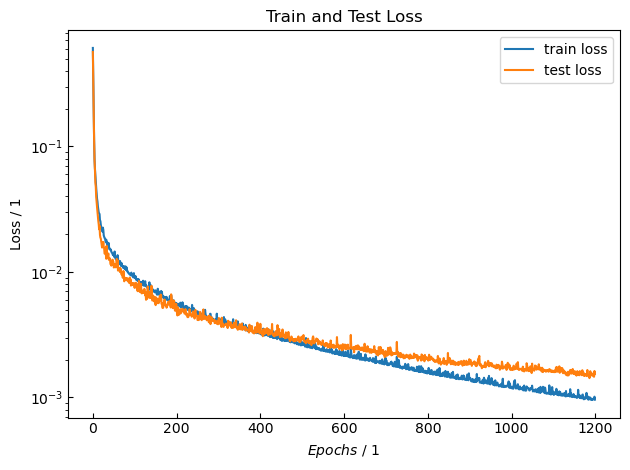

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9990640324964386 , R^2(NH3) = 0.9976344814148526
Test Dataset: R^2(H2) = 0.9986707974707992 , R^2(NH3) = 0.9973018431193431
Max Error Training: |x_H2 - x_H2,pred| = 0.03316896354760307 , |x_NH3 - x_NH3,pred| = 0.03097898773042651
Max Error Test: |x_H2 - x_H2,pred| = 0.026011980679625957 , |x_NH3 - x_NH3,pred| = 0.033002898248807866


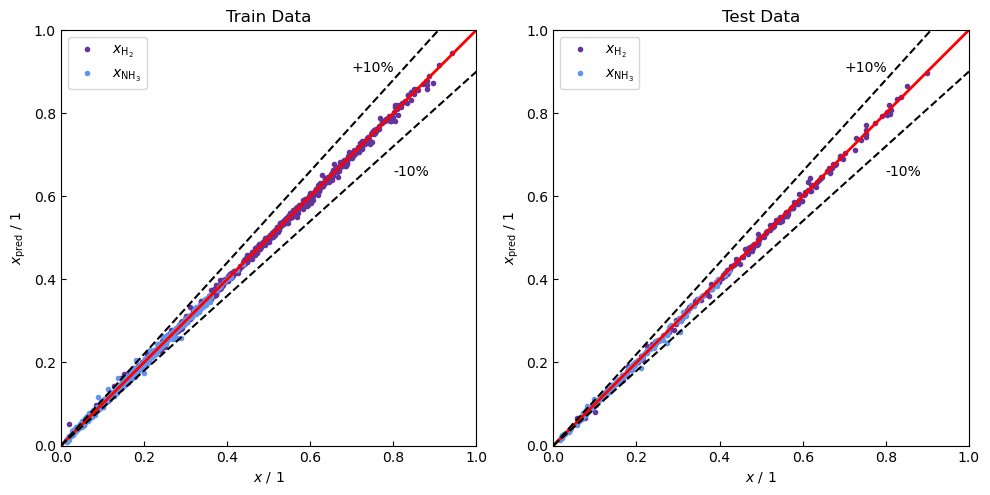

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

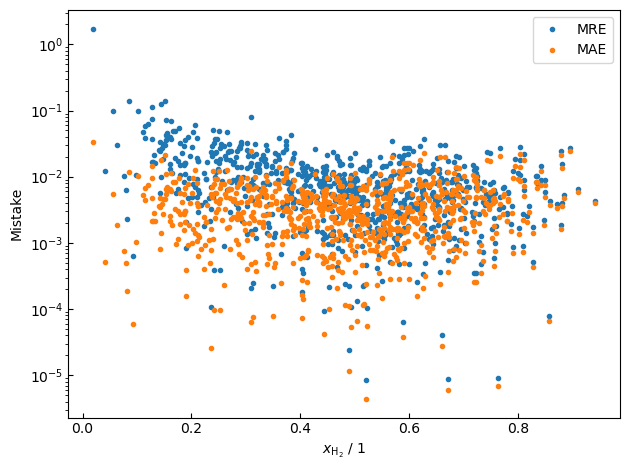

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

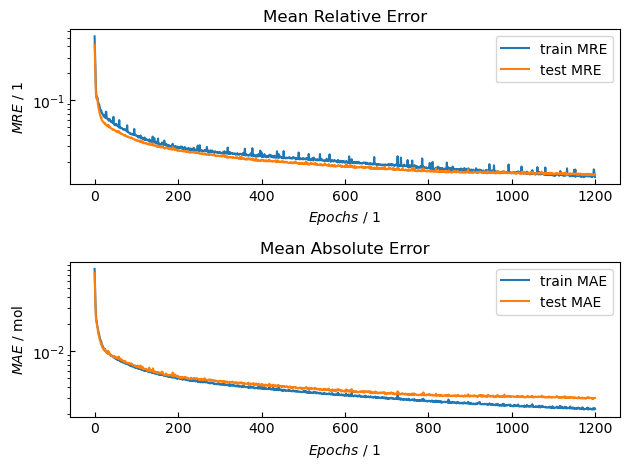

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

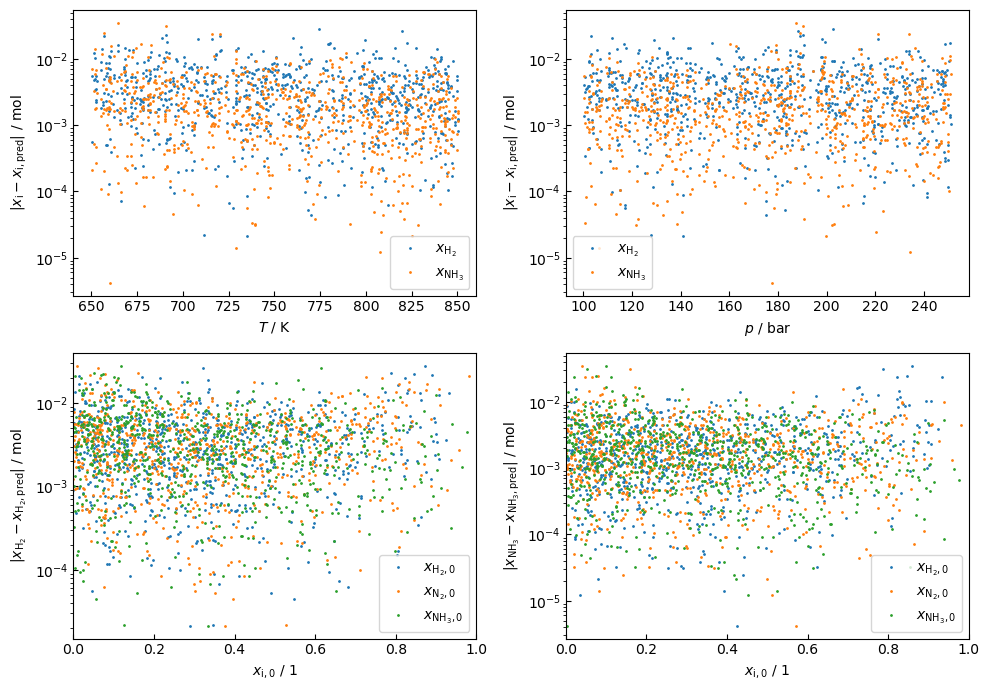

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

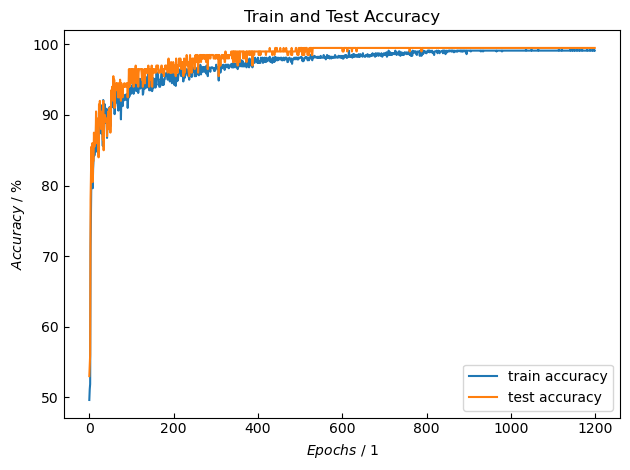

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.4926e+00, -6.4122e-01, -3.3851e-01, -1.5372e-01,  4.8932e-01],
        [ 1.4029e+00,  1.3636e+00,  1.1425e-01, -1.0628e+00,  9.7412e-01],
        [-1.1767e+00,  9.6198e-01,  1.4423e+00, -1.2923e+00, -9.4698e-02],
        [-1.3352e-01,  9.9868e-01, -1.2047e+00,  2.2949e+00, -1.1633e+00],
        [-8.6655e-01,  6.9624e-01, -3.9661e-01,  2.9290e-02,  3.5929e-01],
        [-1.4867e+00, -1.1825e-01,  8.6734e-01,  1.8646e-01, -1.0418e+00],
        [-1.0993e+00, -1.2398e+00, -1.1145e-01,  3.1370e-01, -2.1125e-01],
        [-1.8091e-01, -1.4866e+00, -6.5910e-01,  1.1967e+00, -5.7630e-01],
        [-5.1265e-01,  9.0194e-01,  1.2347e-01, -1.4353e-01,  2.5528e-02],
        [-1.0719e+00,  1.2129e+00,  6.9923e-01, -4.7566e-01, -2.0005e-01],
        [-9.0842e-01, -1.2030e+00,  1.6249e+00, -5.6415e-01, -1.0180e+00],
        [-1.3018e+00,  7.0996e-01, -1.1304e+00,  1.7055e+00, -6.3378e-01],
        [ 1.5639e-01,  4.6021e-03, -5.6245e-01, -1.2557e+00,  1.8354e+00],
        [ 1.0665e+00,  1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 8.0333e-02, -1.6383e-01, -2.3139e-01, -2.1148e-01,  5.8986e-02],
         [ 3.9455e-01,  4.3300e-01, -7.3945e-03,  4.2235e-01,  2.2645e-02],
         [-4.2834e-01,  6.9931e-02, -8.1977e-03, -2.5549e-01, -2.6191e-01],
         [-2.7258e-01,  6.3698e-02,  5.4578e-02,  8.5723e-02, -3.5292e-01],
         [ 1.5673e-01, -2.3347e-01,  2.1897e-01, -2.8647e-01,  2.5850e-01],
         [ 4.0717e-01,  3.7057e-01,  1.5369e-01,  8.6827e-02, -1.2993e-01],
         [ 1.1326e-01, -3.9833e-01, -1.9031e-01,  4.0127e-01,  3.9132e-01],
         [-2.2104e-01,  2.2923e-01,  5.9663e-02,  3.1093e-01,  7.4933e-02],
         [ 1.9572e-01, -1.3785e-01, -1.0397e-01, -1.6973e-01,  1.5169e-01],
         [ 1.7382e-01, -2.8682e-01,  3.7889e-01,  2.8800e-01, -4.3283e-01],
         [ 5.8503e-02,  3.1362e-01,  2.4849e-01, -3.8413e-02, -8.1772e-02],
         [ 2.0108e-02, -2.9855e-01, -3.6623e-01, -3.9773e-01, -3.6204e-01],
         [ 1.3500e-01,  2.1200e-01,  3.4701e-01, -1.2217e-01, -3.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6837, 0.3785, 0.6648, 0.0171, 0.2151],
        [0.4980, 0.2629, 0.8750, 0.3264, 0.6148]])
tensor([[ 0.4816, -0.2646],
        [ 0.4714, -0.2921]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-2.1849e-01,  1.3309e-01, -1.0097e-02,  1.1138e+00, -1.1284e+00],
        [-1.3124e+00, -4.5486e-01, -6.9774e-01,  7.1873e-01, -4.9840e-02],
        [-1.0751e+00, -5.4105e-01, -7.6198e-01, -8.0966e-01,  1.5753e+00],
        [-1.4601e+00,  4.0222e-01,  8.9972e-01, -7.6124e-01, -1.0493e-01],
        [ 3.9241e-01, -1.5774e+00,  1.3533e-01, -6.1199e-01,  4.9269e-01],
        [-1.5800e+00, -3.8601e-01,  4.7212e-03,  9.0382e-01, -9.2840e-01],
        [ 1.2295e+00, -1.2447e+00, -2.8283e-01, -1.2922e+00,  1.5983e+00],
        [-4.2120e-01,  1.5532e-01, -1.1526e+00, -1.1303e+00,  2.2864e+00],
        [ 5.3817e-01,  1.4841e+00,  4.3640e-01, -1.4327e-01, -2.8184e-01],
        [ 1.4035e+00,  5.9408e-01, -6.3031e-01, -9.4790e-01,  1.5874e+00],
        [ 1.6121e+00,  5.5167e-01, -1.2638e-01, -6.5691e-01,  7.9544e-01],
        [-1.0078e+00, -2.4737e-01, -2.4922e-01, -3.9616e-01,  6.4948e-01],
        [-9.8495e-01,  1.4651e+00,  5.7657e-01, -5.5475e-01,  1.1575e-03],
        [-1.5295e+00, -1.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()